In [25]:
import numpy as np
import scipy as scipy
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt
from kneed import KneeLocator 

In [26]:
np.random.seed(42)

def generate_rand_system(m,n, cond, noise_std = 0):
    #diag_vals = ((np.random.randn(n)*10).round() + 1)**cond
    #diag_matrix = np.diag(diag_vals)

    M = np.random.randn(n, n)
    Q1,_ = np.linalg.qr(M)
    M = np.random.randn(n, n)
    Q2,_ = np.linalg.qr(M)
    U = Q1 @ np.diag(1 / np.arange(1,n+1)**cond) @ Q2.T

    A = np.random.randn(m,n) @ U
    x_true = np.random.randn(n)
    b_clean = A @ x_true
    noise = noise_std * np.random.randn(m)
    b = b_clean + noise
    x_star = np.linalg.lstsq(A,b)[0] #even though b = Ax, block Kaczmarz projects onto minimum norm solution of Ax = b, i.e. x_star.
    return A, b, x_true, x_star

In [27]:
def optimal_s_lambda(A, C, k):
    """
    Find optimal values of lambda and block size
    """
    m = np.shape(A)[0]
    u, s, vt = np.linalg.svd(A)
    tail = s[k:]
    k_bar_k = (np.linalg.norm(A, ord = "fro") / np.min(tail)) / np.sqrt(len(tail))   #normalized tail condition number
    
    optimal_s = np.ceil(C * k * np.log(m * k_bar_k)) # optimal block size
    optimal_lambda = (np.sum(tail ** 2))/k
    return optimal_s, optimal_lambda

In [28]:
def calculate_lamda_mu_nu(A, k):
    """
    Estimate lambda, mu, and nu from A^T A.
    k is block size
    """
    s2 = np.linalg.eigvalsh(A)
    s2[s2 < np.mean(s2) * 1e-8] = 0

    def f(lamda):
        return np.sum(s2 / (s2 + lamda)) - k

    lamda = root_scalar(f, bracket=[1e-8, np.max(s2) * len(s2) * 1e8]).root
    s2_min = np.min(s2[s2 > 0])
    mu = s2_min / (s2_min + lamda)
    num = np.sum((s2 > 0) / (s2 + lamda))
    denom = np.sum(s2 / (s2 + lamda)**2)
    lamda_prime = lamda * num / denom
    nu = 1 + lamda_prime / (s2_min + lamda)

    return lamda, mu, nu

In [29]:
def update_rho_adaptive(residuals, ti, i, p, r_hat_prev, alpha_prev):
    """
    Adaptive rho update based on averaged residual norm squared ratios.
    """
    #eps_t = np.linalg.norm(residuals[ti])**2
    #eps_tp = np.linalg.norm(residuals[ti - p])**2 #np.mean([r**2 for r in residuals[-2*p:-p]])
    eps_t = np.sum(np.array(residuals[ti-p:ti])**2)
    eps_tp = np.sum(np.array(residuals[ti-2*p:ti-p])**2)
    r_ip = eps_t / eps_tp

    a_new = (i + 1) ** np.log(i + 1)
    a_old = (i) ** np.log(i)
    alpha = a_old/a_new
    #alpha = (alpha_prev) / a_ti

    r_hat = alpha * r_hat_prev + (1 - alpha) * min(1, r_ip)
    rho_new = max(0, 1 - r_hat ** (1 / p))
    #rho_new = max(min(rho_new, 1), 0.0)  # clamp rho to [0, 1] to avoid negative rhos, causing divergence

    return rho_new, r_hat, alpha

In [39]:
def kaczmarz(A, b, lamb, accelerated, eta, rho, n_steps, block_size, p, x_true = None):
    m, n = A.shape
    x = np.zeros(n)
    residuals = []
    residual_norms = []
    update_norms = []
    errors = []
    rhos = []
    
    mtm = 0
    #mtm_param = 1.0 if accelerated else 0.0
    if accelerated:
        #mtm_param = (1 - rho)/(1 + rho)
        mtm_param = 0.9
    else:
        mtm_param = 0
        
    r_hat = 1
    checkpoint_idx = 1
    #nu = 2*n/block_size
    #eta = 1/nu # start eta at 0, doesn't change until first momentum update --> causes massive spike 
    #eta = 0
    
    b_norm = np.linalg.norm(b)
    
    for t in range(n_steps):
        tau = np.random.choice(m, block_size, replace=False)
        A_tau = A[tau, :]
        b_tau = b[tau]
    
        #regularized projection: 
        cho = scipy.linalg.cho_factor(A_tau @ A_tau.T + lamb * np.eye(block_size))
        w = A_tau.T @ scipy.linalg.cho_solve(cho, (A_tau @ x - b_tau)) 
        #w = np.linalg.lstsq(A_tau, A_tau @ x - b_tau)[0]
        mtm = mtm_param * (mtm - w)
        x = x - w + eta * mtm

        #storing residual, which should be getting smaller
        system = A @ x - b
        residuals.append(np.linalg.norm(system))
        residual_norms.append(np.linalg.norm(system) / b_norm)

        #storing error
        if x_true is not None:
            errors.append(np.linalg.norm(x - x_true))

        if t % p == 0 and t >= 2 * p and accelerated:
            #rho, r_hat, alpha = update_rho_adaptive(residuals, t, checkpoint_idx, p, r_hat, alpha)
            eps_t = np.sum(np.array(residuals[t-p:t])**2)
            eps_tp = np.sum(np.array(residuals[t-2*p:t-p])**2)
            r_ip = eps_t / eps_tp

            a_new = (checkpoint_idx + 1) ** np.log(checkpoint_idx + 1)
            a_old = (checkpoint_idx) ** np.log(checkpoint_idx)
            alpha = a_old/a_new
        
            r_hat = alpha * r_hat + (1 - alpha) * min(1, r_ip)
            rho = max(0, 1 - r_hat ** (1 / p))
            mtm_param = (1-rho)/(1+rho)
            #eta = 1/nu
            checkpoint_idx += 1
        
        rhos.append(rho)#!!!!!

    return x, residuals, residual_norms, update_norms, errors, rhos

In [31]:
def verify(A, b, l, r, e, bl_s, x_true):
     #Run Kaczmarz
    x_kacz, residuals, residual_norms, update_norms, errors, rhos = kaczmarz(A, b, lamb = l, rho = r, eta = e, n_steps = 10, block_size = bl_s, p = 10, x_true = x_true)

    #Plot metrics
    fig, axs = plt.subplots(3, 1, figsize=(10, 10))

    axs[0].plot(residuals)
    axs[0].set_title("1. Residual Norm ||Ax - b|| (inconsistent system)")
    axs[0].set_xlabel("Iteration")
    axs[0].set_ylabel("Residual")

    axs[1].plot(update_norms)
    axs[1].set_title("2. Update Norm ||x_{t+1} - x_t||")
    axs[1].set_xlabel("Iteration")
    axs[1].set_ylabel("Update Size")

    axs[2].plot(errors)
    axs[2].set_title("3. Error Norm ||x - x_true||")
    axs[2].set_xlabel("Iteration")
    axs[2].set_ylabel("Error")

    plt.tight_layout()
    plt.show()


In [32]:
def k_singular_values(A):
    u, sing, vt = np.linalg.svd(A)
    knee = KneeLocator(range(len(sing)), sing, curve='convex', direction='decreasing')
    return knee.knee + 1
    # second_diff = np.diff(sing, n=2)
    # elbow_index = np.argmax(second_diff) + 1 
    # #num_outliers = elbow_index + 1
    # return elbow_index

/var/folders/9g/0d0k7mbj6v39ndl2dz1yc49w0000gn/T/ipykernel_45296/1784429245.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x_star = np.linalg.lstsq(A,b)[0] #even though b = Ax, block Kaczmarz projects onto minimum norm solution of Ax = b, i.e. x_star.


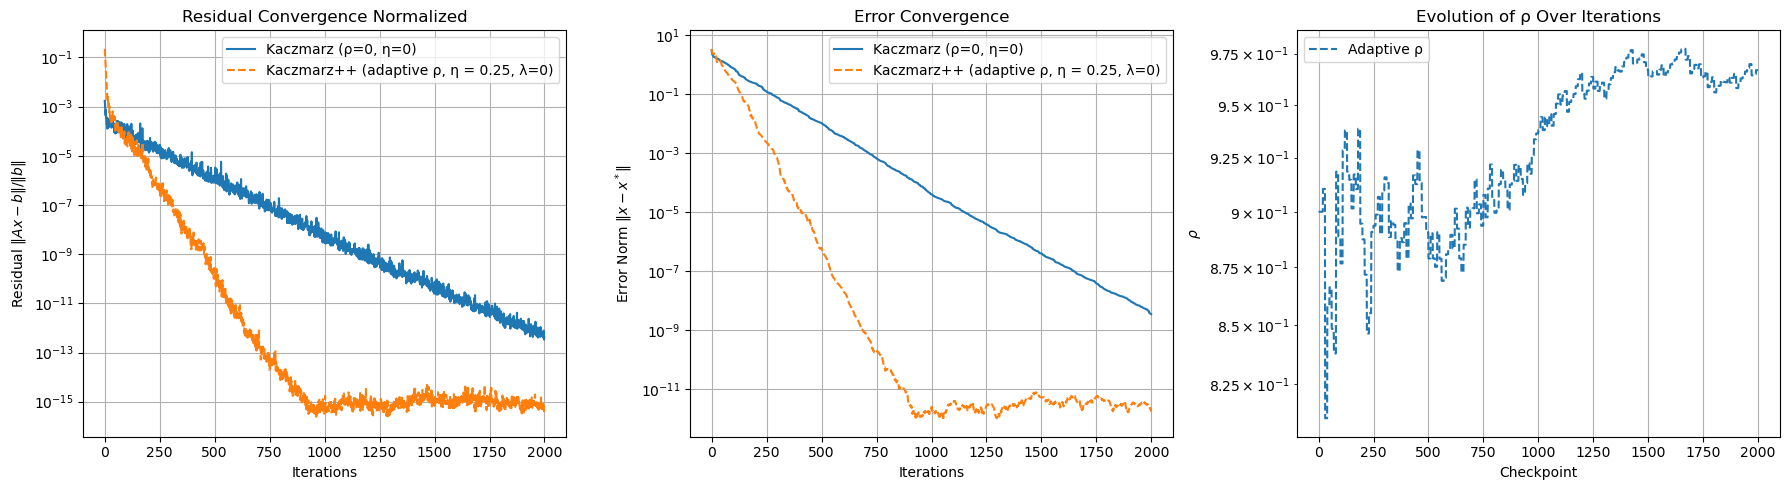

block size: 10


In [33]:
np.random.seed(42)

m = 50
n = 20

A, b, x_true, x_star = generate_rand_system(m, n, 3, noise_std = 0)
k = k_singular_values(A)

#block size, lambda
#s = optimal_s_lambda(A, 1, k)[0].astype(int)
s = 10
# lamb = optimal_s_lambda(A, 1, k)[1]
lamb = 0

#lamb = calculate_lamda_mu_nu(A.T @ A, s)[0]
#eta = s/(2*calculate_lamda_mu_nu(A.T @ A, s)[2])
#lamb = 0.001
eta = s/(2*n)

#no adaptive acceleration
x_kacz_reg, residuals_reg, residual_norms_reg, update_norms_reg, errors_reg, rhos_reg = kaczmarz(A, b, lamb = lamb, accelerated = False, eta = 0, rho = 0, n_steps = 2000, block_size = s, p = 10, x_true = x_true)
#adaptive acceleration
x_kacz_aa, residuals_reg_aa, residual_norms_aa, update_norms_reg_aa, errors_reg_aa, rhos_aa = kaczmarz(A, b, lamb = lamb, accelerated = True, eta = eta, rho = 0.9, n_steps = 2000, block_size = s, p = 10, x_true = x_true)


fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Residual
axs[0].plot(residual_norms_reg, label="Kaczmarz (ρ=0, η=0)")
axs[0].plot(residual_norms_aa, label=f"Kaczmarz++ (adaptive ρ, η = {eta}, λ={lamb:.3g})", linestyle='--')
axs[0].set_yscale("log")
axs[0].set_title("Residual Convergence Normalized")
axs[0].set_xlabel("Iterations")
axs[0].set_ylabel(r"Residual $\|Ax - b\| / \|b\|$")
axs[0].legend()
axs[0].grid(True)

# Error
axs[1].plot(errors_reg, label="Kaczmarz (ρ=0, η=0)")
axs[1].plot(errors_reg_aa, label=f"Kaczmarz++ (adaptive ρ, η = {eta}, λ={lamb:.3g})", linestyle='--')
axs[1].set_yscale("log")
axs[1].set_title("Error Convergence")
axs[1].set_xlabel("Iterations")
axs[1].set_ylabel(r"Error Norm $\|x - x^*\|$")
axs[1].legend()
axs[1].grid(True)

# Adaptive ρ
axs[2].plot(rhos_aa, label="Adaptive ρ", linestyle='--')
axs[2].set_yscale("log")
axs[2].set_title("Evolution of ρ Over Iterations")
axs[2].set_xlabel("Checkpoint")
axs[2].set_ylabel(r"$\rho$")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

print(f"block size: {s}")

/tmp/ipykernel_19161/1784429245.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x_star = np.linalg.lstsq(A,b)[0] #even though b = Ax, block Kaczmarz projects onto minimum norm solution of Ax = b, i.e. x_star.
/tmp/ipykernel_19161/3460248849.py:33: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = np.linalg.lstsq(A_tau, A_tau @ x - b_tau)[0]


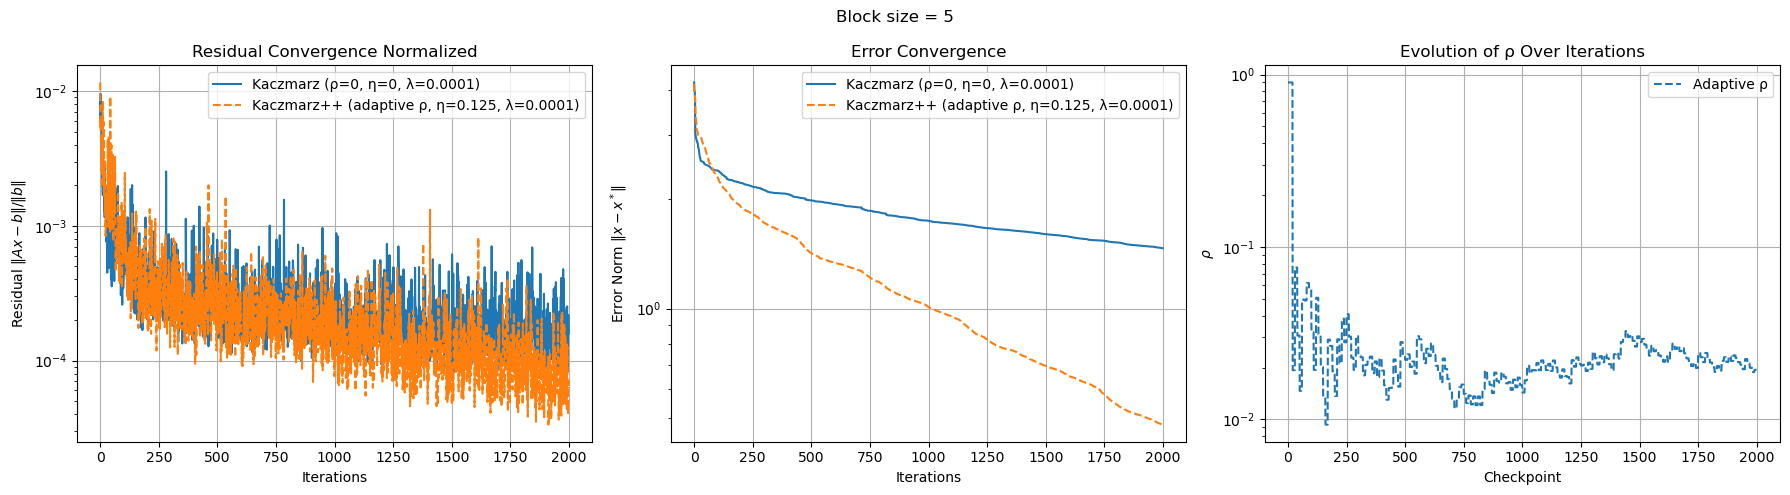

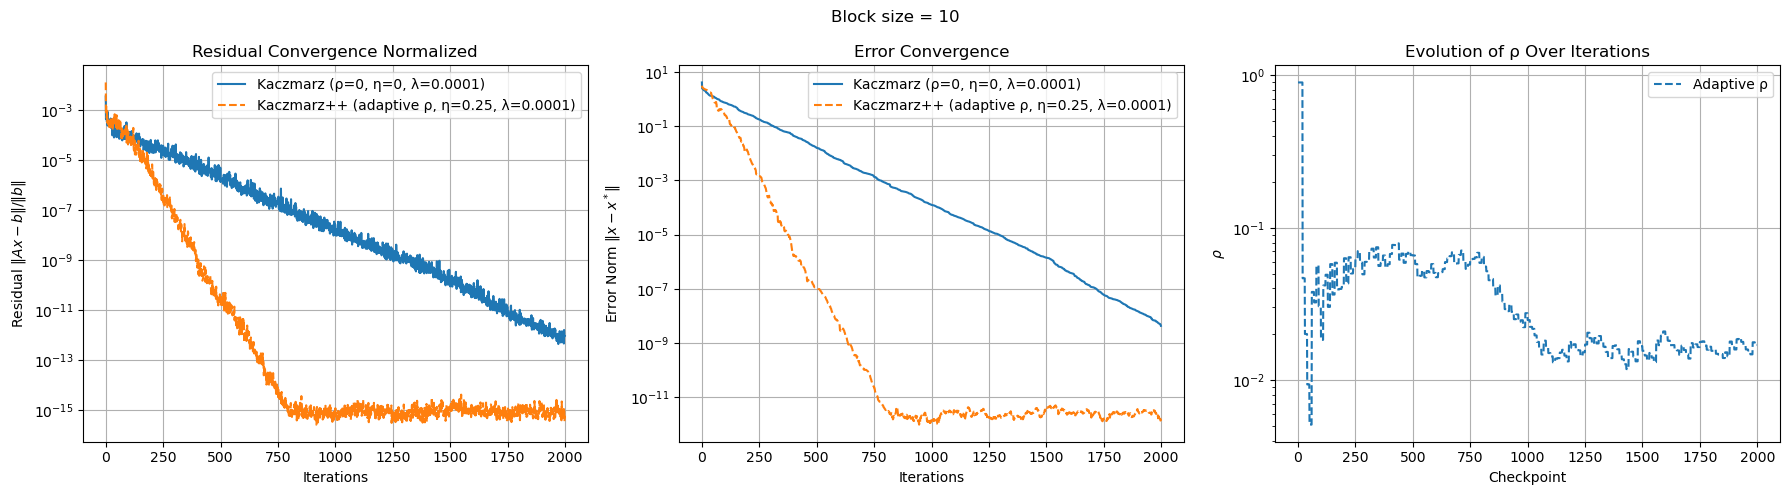

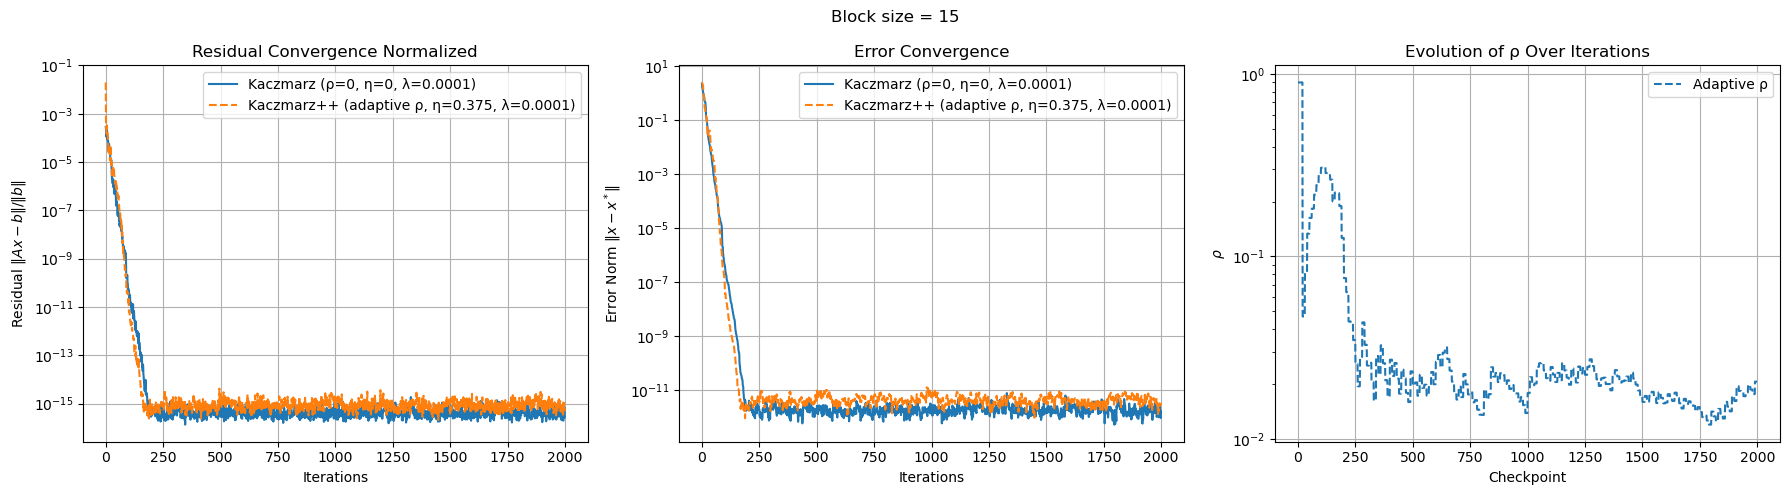

In [54]:
np.random.seed(42)

potential_block_sizes = np.array([5, 10, 15])

m = 50
n = 20
A, b, x_true, x_star = generate_rand_system(m, n, 3, noise_std = 0)
k = k_singular_values(A)

#block size, lambda
#s = optimal_s_lambda(A, 1, k)[0].astype(int)
#lamb = optimal_s_lambda(A, 1, k)[1]
lamb = 0.0001
lamb_reg = lamb

for size in potential_block_sizes:
    eta = size/(2*n)
    #lamb_aa = calculate_lamda_mu_nu(A.T @ A, size)[0]
    #lamb_aa = optimal_s_lambda(A, 1, k)[1]
    lamb_aa = lamb
    #no adaptive acceleration
    x_kacz_reg, residuals_reg, residual_norms_reg, update_norms_reg, errors_reg, rhos_reg = kaczmarz(A, b, lamb = lamb, accelerated = False, rho = 0, eta = 0, n_steps = 2000, block_size = size, p = 10, x_true = x_star)
    #adaptive acceleration
    x_kacz_aa, residuals_reg_aa, residual_norms_aa, update_norms_reg_aa, errors_reg_aa, rhos_aa = kaczmarz(A, b, lamb = lamb, accelerated = True, rho = 0.9, eta = eta, n_steps = 2000, block_size = size, p = 10, x_true = x_star)


    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"Block size = {size}")

    # Residual
    axs[0].plot(residual_norms_reg, label=f"Kaczmarz (ρ=0, η=0, λ={lamb_reg:.3g})")
    axs[0].plot(residual_norms_aa, label=f"Kaczmarz++ (adaptive ρ, η={eta:.3g}, λ={lamb_aa:.3g})", linestyle='--')
    axs[0].set_yscale("log")
    axs[0].set_title("Residual Convergence Normalized")
    axs[0].set_xlabel("Iterations")
    axs[0].set_ylabel(r"Residual $\|Ax - b\| / \|b\|$")
    axs[0].legend()
    axs[0].grid(True)
    
    # Error
    axs[1].plot(errors_reg, label=f"Kaczmarz (ρ=0, η=0, λ={lamb_reg:.3g})")
    axs[1].plot(errors_reg_aa, label=f"Kaczmarz++ (adaptive ρ, η={eta:.3g}, λ={lamb_aa:.3g})", linestyle='--')
    axs[1].set_yscale("log")
    axs[1].set_title("Error Convergence")
    axs[1].set_xlabel("Iterations")
    axs[1].set_ylabel(r"Error Norm $\|x - x^*\|$")
    axs[1].legend()
    axs[1].grid(True)
    
    # Adaptive ρ
    axs[2].plot(rhos_aa, label="Adaptive ρ", linestyle='--')
    axs[2].set_yscale("log")
    axs[2].set_title("Evolution of ρ Over Iterations")
    axs[2].set_xlabel("Checkpoint")
    axs[2].set_ylabel(r"$\rho$")
    axs[2].legend()
    axs[2].grid(True)
    
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_19161/1784429245.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x_star = np.linalg.lstsq(A,b)[0] #even though b = Ax, block Kaczmarz projects onto minimum norm solution of Ax = b, i.e. x_star.
/tmp/ipykernel_19161/3460248849.py:33: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = np.linalg.lstsq(A_tau, A_tau @ x - b_tau)[0]


block size: 74


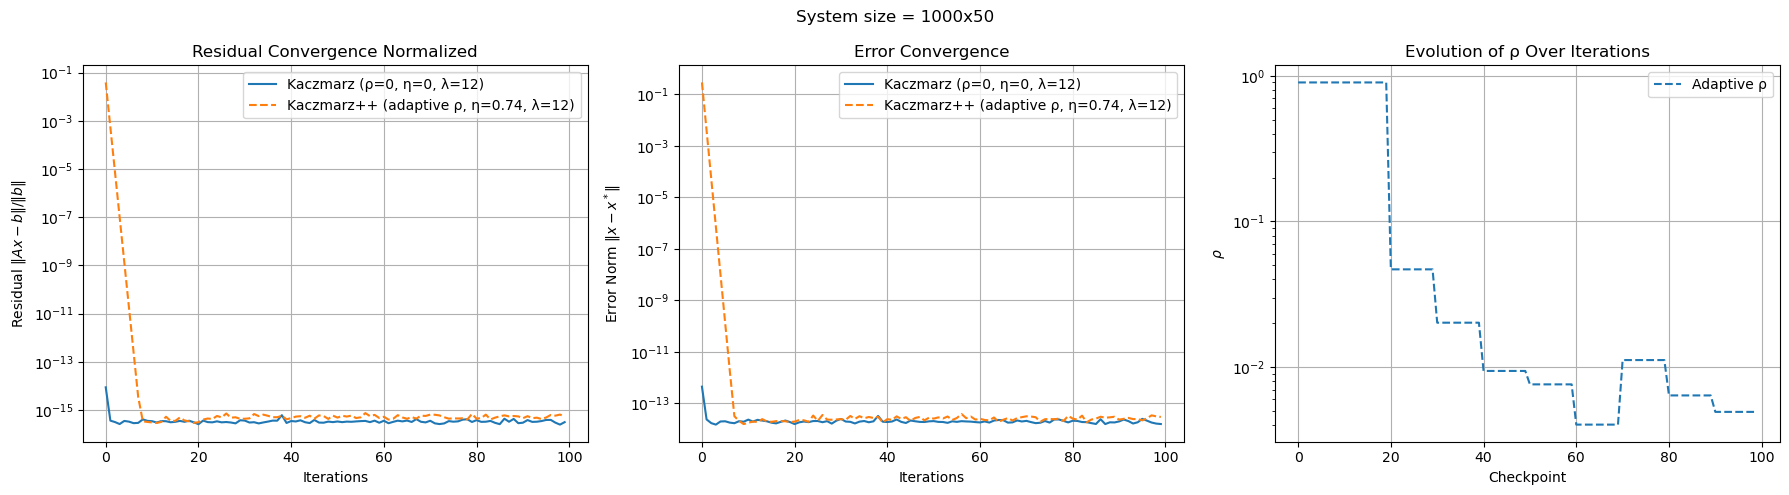

block size: 97


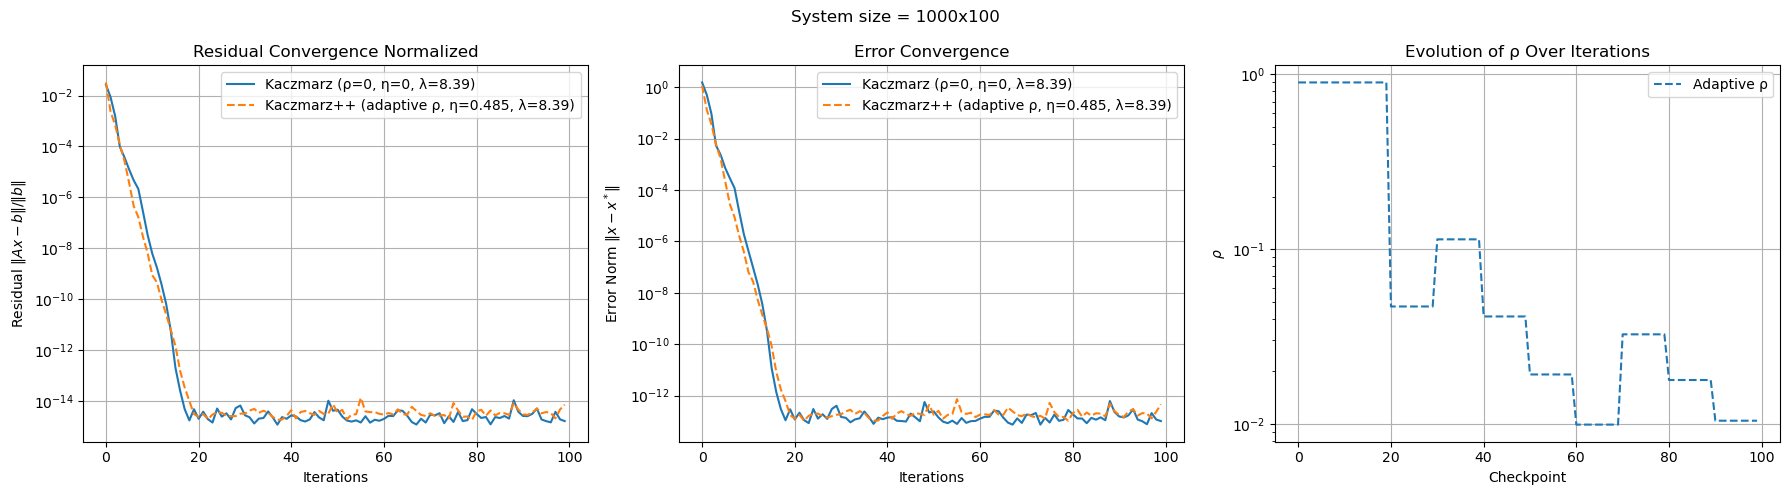

block size: 140


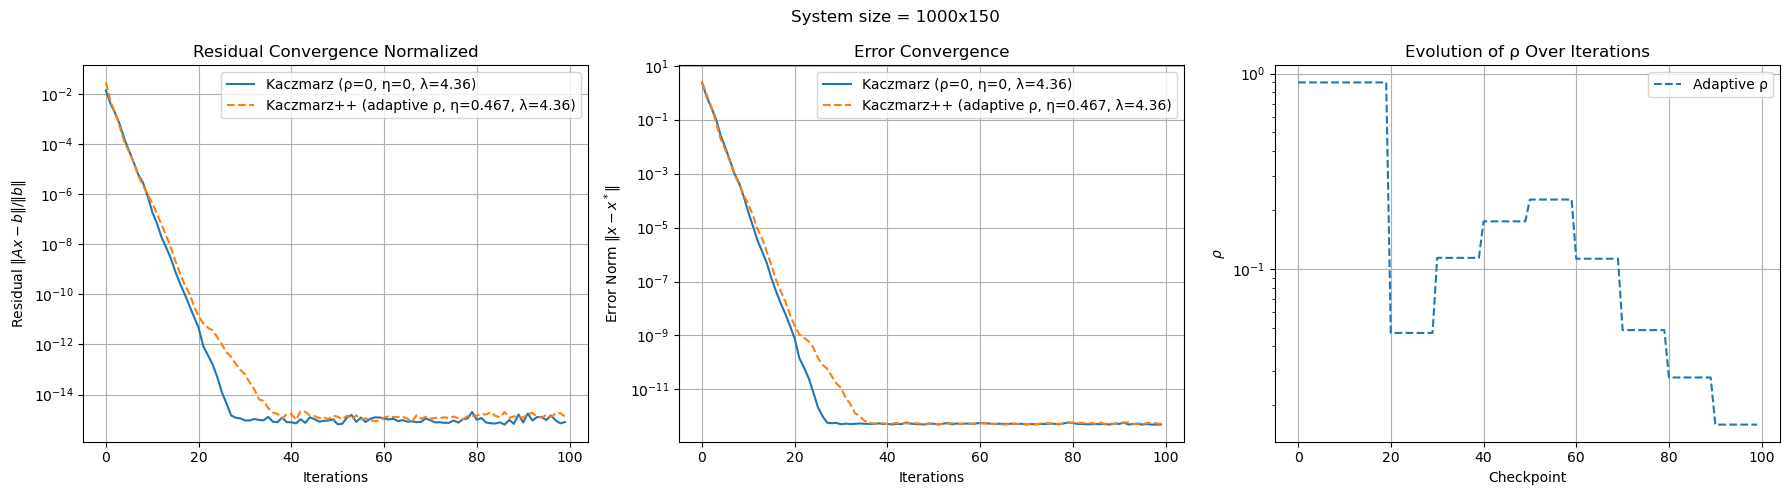

block size: 182


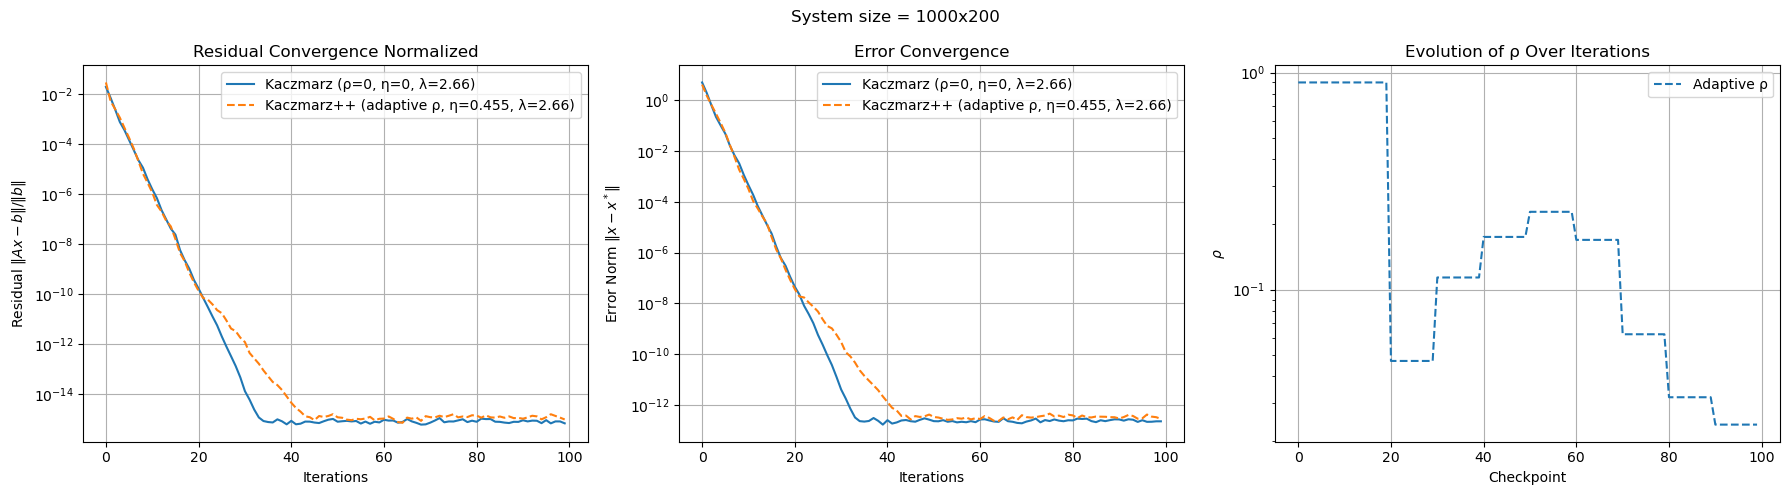

In [55]:
np.random.seed(42)

potential_n_values = np.array([50, 100, 150, 200])

m = 1000
for pot_n in potential_n_values:
    A, b, x_true, x_star = generate_rand_system(m, pot_n, cond=1)
    k = k_singular_values(A)
    s = optimal_s_lambda(A, 1, k)[0].astype(int)
    print(f"block size: {s}")
    lamb = optimal_s_lambda(A, 1, k)[1]
    #lamb = calculate_lamda_mu_nu(A.T @ A, s)[0]
    #lamb = 0.001
    
    eta = s/(2*pot_n)
    #no adaptive acceleration
    x_kacz_reg, residuals_reg, residual_norms_reg, update_norms_reg, errors_reg, rhos_reg = kaczmarz(A, b, lamb = lamb, accelerated = False, rho = 0, eta = 0, n_steps = 100, block_size = s, p = 10, x_true = x_star)
    #adaptive acceleration
    x_kacz_aa, residuals_reg_aa, residual_norms_aa, update_norms_reg_aa, errors_reg_aa, rhos_aa = kaczmarz(A, b, lamb = lamb, accelerated = True, rho = 0.9, eta = eta, n_steps = 100, block_size = s, p = 10, x_true = x_star)

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"System size = 1000x{pot_n}")

    # Residual
    axs[0].plot(residual_norms_reg, label=f"Kaczmarz (ρ=0, η=0, λ={lamb:.3g})")
    axs[0].plot(residual_norms_aa, label=f"Kaczmarz++ (adaptive ρ, η={eta:.3g}, λ={lamb:.3g})", linestyle='--')
    axs[0].set_yscale("log")
    axs[0].set_title("Residual Convergence Normalized")
    axs[0].set_xlabel("Iterations")
    axs[0].set_ylabel(r"Residual $\|Ax - b\| / \|b\|$")
    axs[0].legend()
    axs[0].grid(True)
    
    # Error
    axs[1].plot(errors_reg, label=f"Kaczmarz (ρ=0, η=0, λ={lamb:.3g})")
    axs[1].plot(errors_reg_aa, label=f"Kaczmarz++ (adaptive ρ, η={eta:.3g}, λ={lamb:.3g})", linestyle='--')
    axs[1].set_yscale("log")
    axs[1].set_title("Error Convergence")
    axs[1].set_xlabel("Iterations")
    axs[1].set_ylabel(r"Error Norm $\|x - x^*\|$")
    axs[1].legend()
    axs[1].grid(True)
    
    # Adaptive ρ
    axs[2].plot(rhos_aa, label="Adaptive ρ", linestyle='--')
    axs[2].set_yscale("log")
    axs[2].set_title("Evolution of ρ Over Iterations")
    axs[2].set_xlabel("Checkpoint")
    axs[2].set_ylabel(r"$\rho$")
    axs[2].legend()
    axs[2].grid(True)
    
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_19161/1784429245.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x_star = np.linalg.lstsq(A,b)[0] #even though b = Ax, block Kaczmarz projects onto minimum norm solution of Ax = b, i.e. x_star.


block size: 10


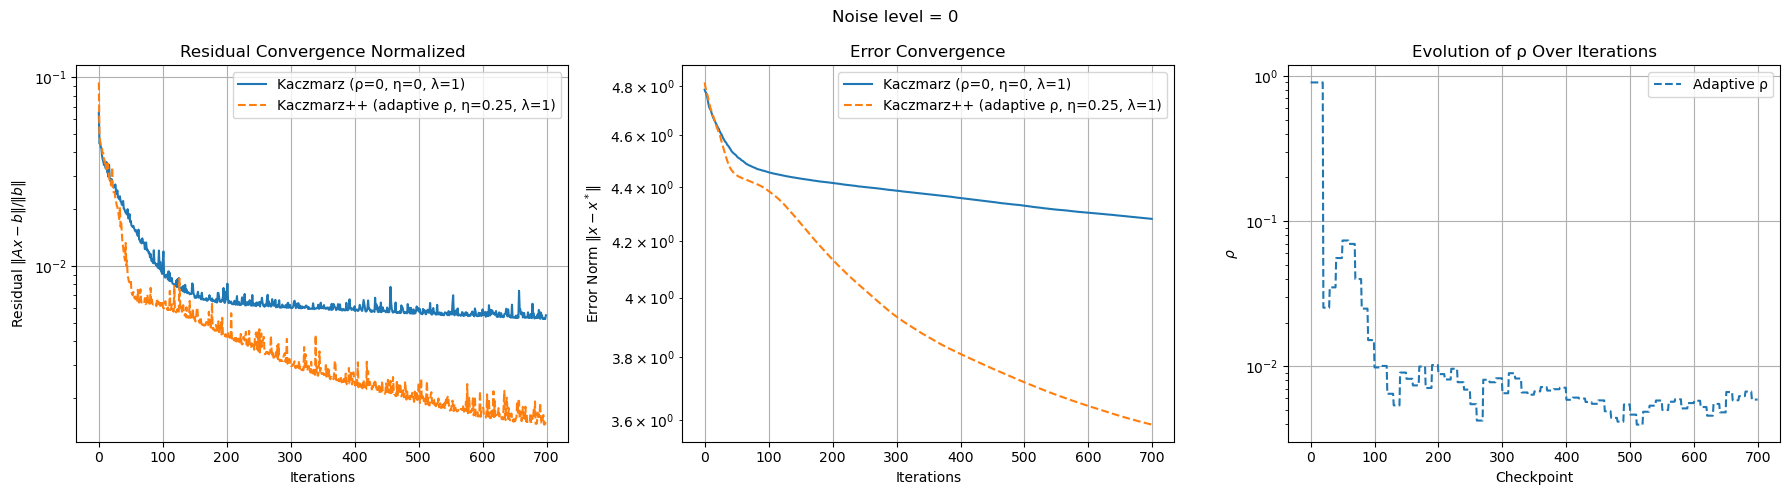

block size: 10


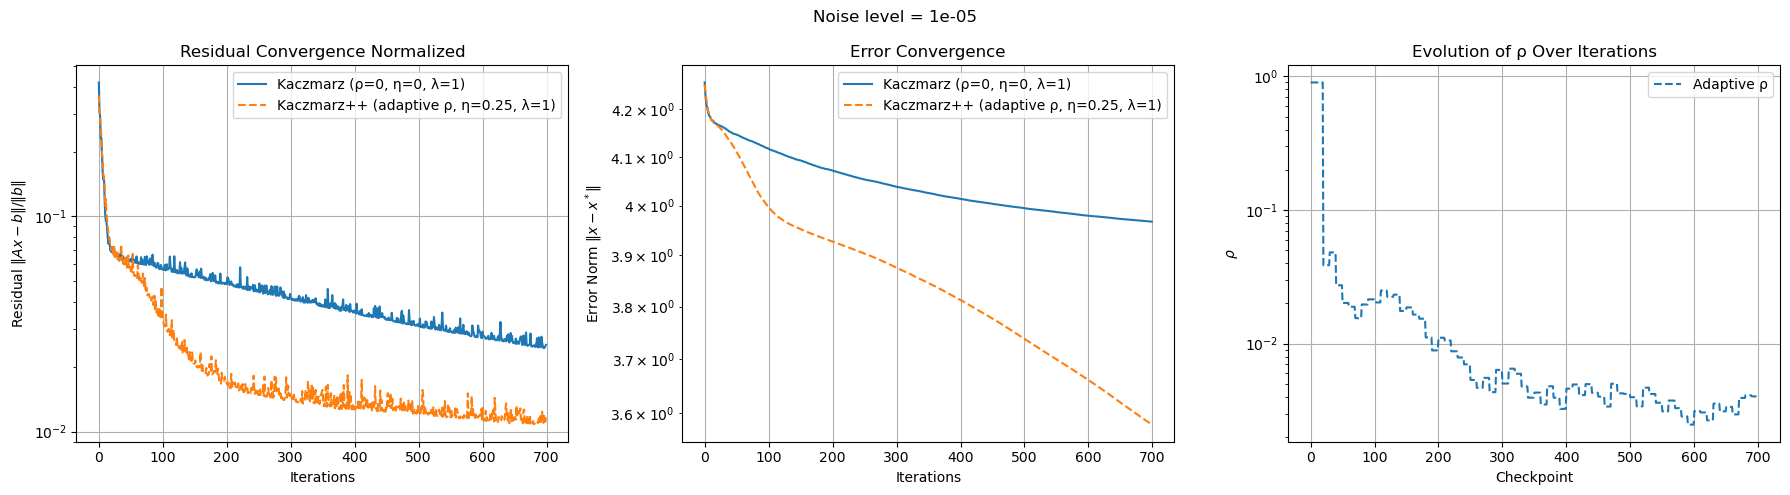

block size: 10


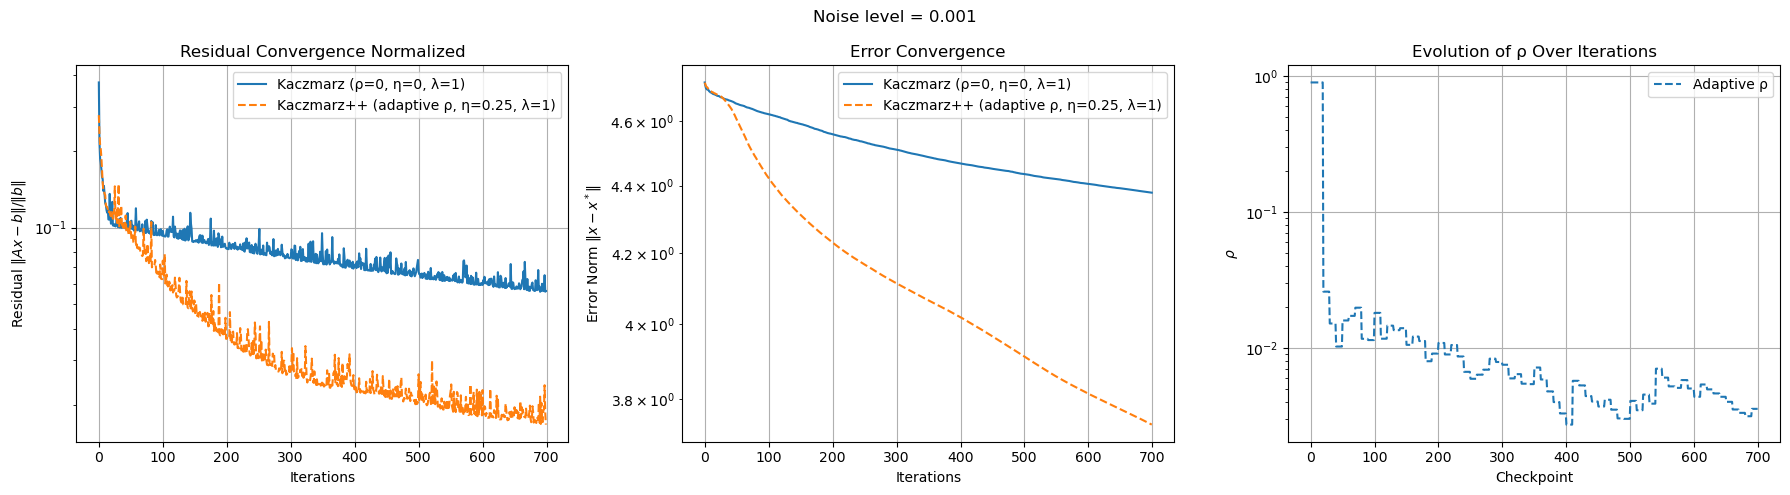

block size: 10


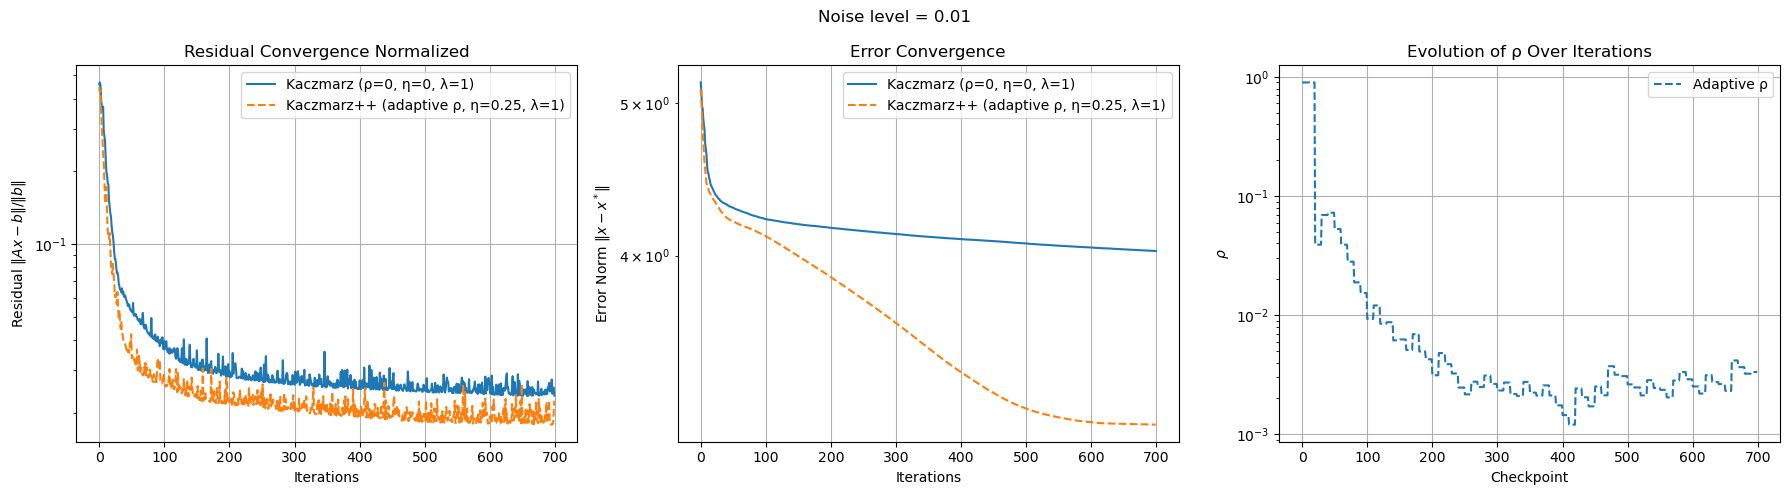

In [80]:
np.random.seed(42)

noise_levels = [0, 1e-5, 1e-3, 1e-2]

m = 50
n = 20 

for noise in noise_levels:
    A, b, x_true, x_star = generate_rand_system(m,n, cond=3, noise_std = noise)
    k = k_singular_values(A)
    #lamb = optimal_s_lambda(A, 1, k)[1]
    lamb = 1
    #s = optimal_s_lambda(A, 1, k)[0].astype(int)
    s = 10
    print(f"block size: {s}")
    eta = s/(2*n)
    #no adaptive acceleration
    x_kacz_reg, residuals_reg, residual_norms_reg, update_norms_reg, errors_reg, rhos_reg = kaczmarz(A, b, lamb = lamb, accelerated = False, rho = 0, eta = 0, n_steps = 700, block_size = s, p = 10, x_true = x_true)
    #adaptive acceleration
    x_kacz_aa, residuals_reg_aa, residual_norms_aa, update_norms_reg_aa, errors_reg_aa, rhos_aa = kaczmarz(A, b, lamb = lamb, accelerated = True, rho = 0.9, eta = eta, n_steps = 700, block_size = s, p = 10, x_true = x_true)

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"Noise level = {noise}")

    # Residual
    axs[0].plot(residual_norms_reg, label=f"Kaczmarz (ρ=0, η=0, λ={lamb:.3g})")
    axs[0].plot(residual_norms_aa, label=f"Kaczmarz++ (adaptive ρ, η={eta:.3g}, λ={lamb:.3g})", linestyle='--')
    axs[0].set_yscale("log")
    axs[0].set_title("Residual Convergence Normalized")
    axs[0].set_xlabel("Iterations")
    axs[0].set_ylabel(r"Residual $\|Ax - b\| / \|b\|$")
    axs[0].legend()
    axs[0].grid(True)
    
    # Error
    axs[1].plot(errors_reg, label=f"Kaczmarz (ρ=0, η=0, λ={lamb:.3g})")
    axs[1].plot(errors_reg_aa, label=f"Kaczmarz++ (adaptive ρ, η={eta:.3g}, λ={lamb:.3g})", linestyle='--')
    axs[1].set_yscale("log")
    axs[1].set_title("Error Convergence")
    axs[1].set_xlabel("Iterations")
    axs[1].set_ylabel(r"Error Norm $\|x - x^*\|$")
    axs[1].legend()
    axs[1].grid(True)
    
    # Adaptive ρ
    axs[2].plot(rhos_aa, label="Adaptive ρ", linestyle='--')
    axs[2].set_yscale("log")
    axs[2].set_title("Evolution of ρ Over Iterations")
    axs[2].set_xlabel("Checkpoint")
    axs[2].set_ylabel(r"$\rho$")
    axs[2].legend()
    axs[2].grid(True)
    
    plt.tight_layout()
    plt.show()
    

/tmp/ipykernel_19161/1784429245.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x_star = np.linalg.lstsq(A,b)[0] #even though b = Ax, block Kaczmarz projects onto minimum norm solution of Ax = b, i.e. x_star.
/tmp/ipykernel_19161/3416238532.py:33: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = np.linalg.lstsq(A_tau, A_tau @ x - b_tau)[0]


block size: 10


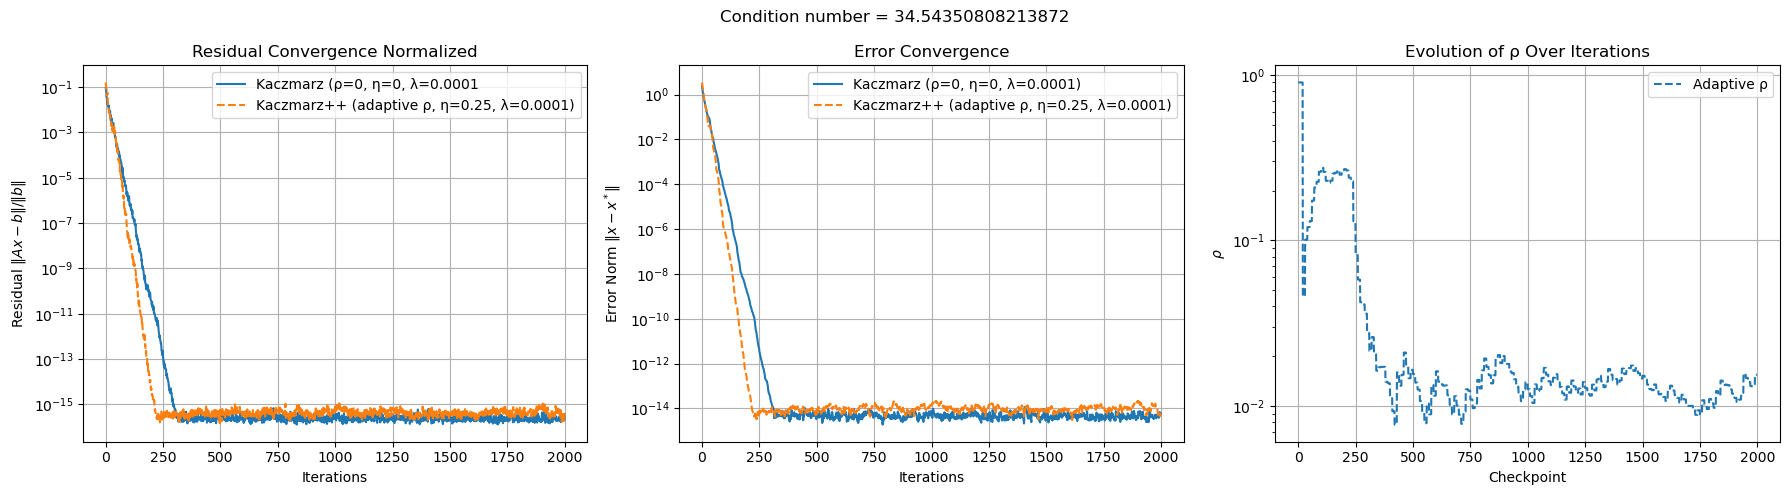

block size: 10


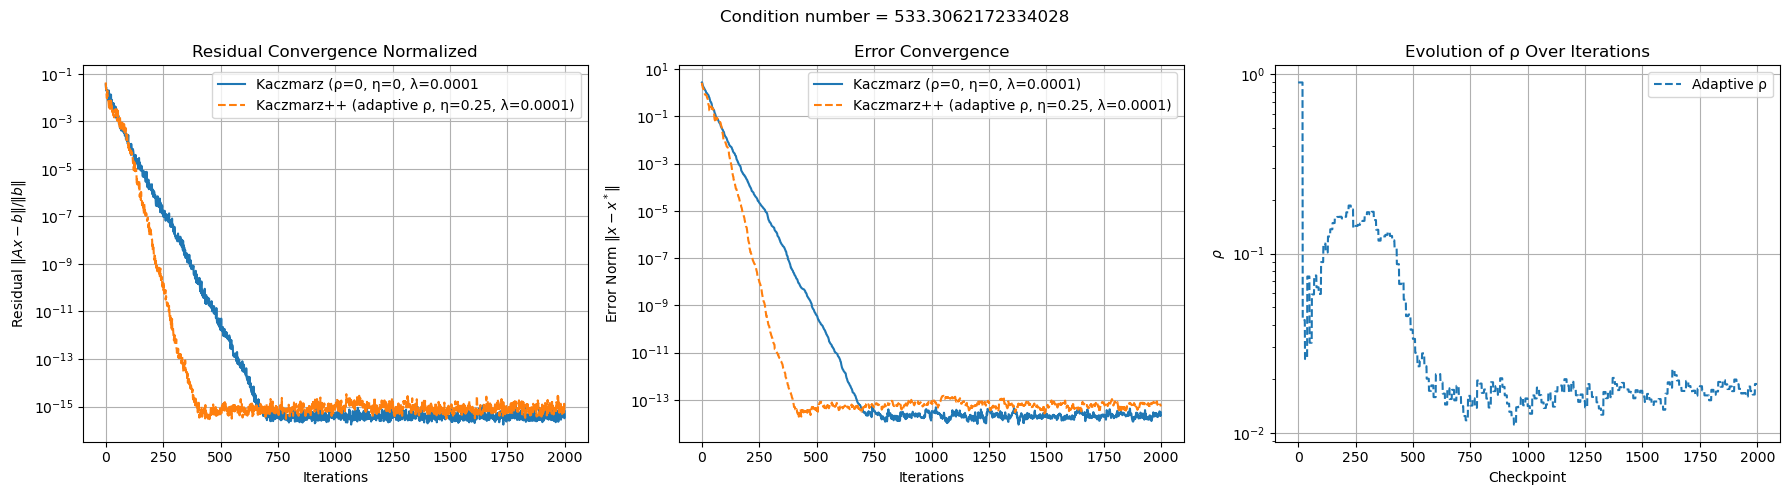

block size: 10


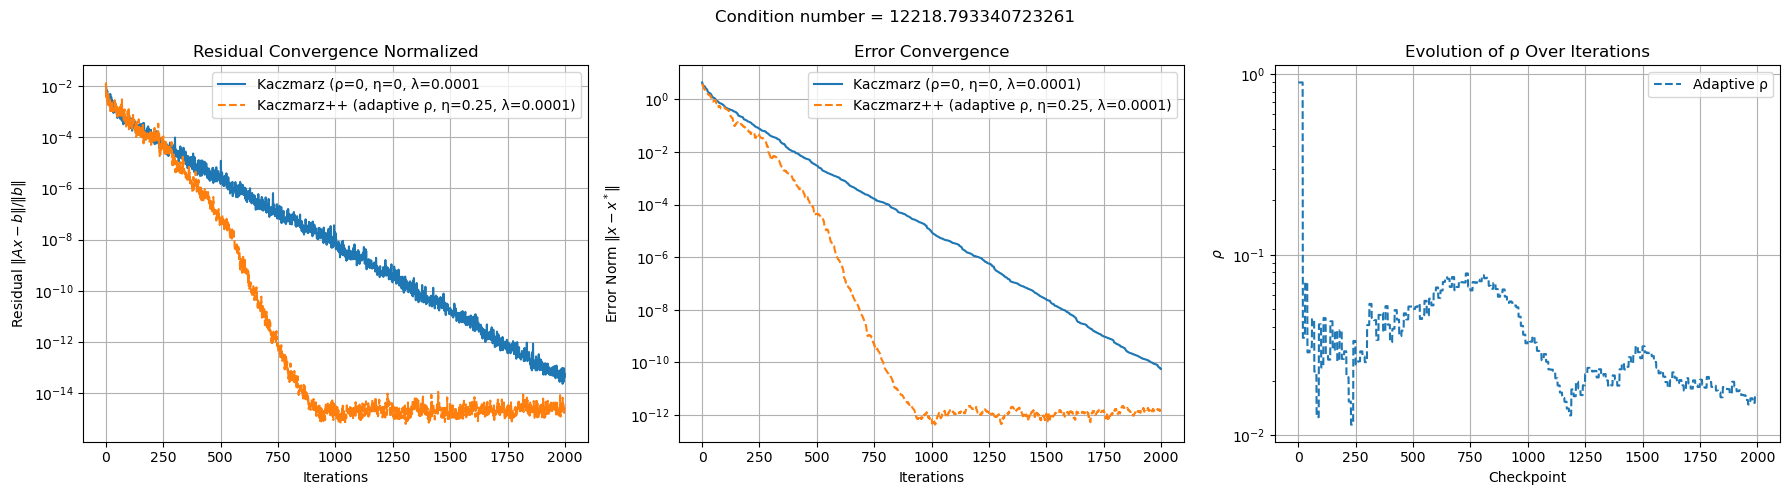

block size: 10


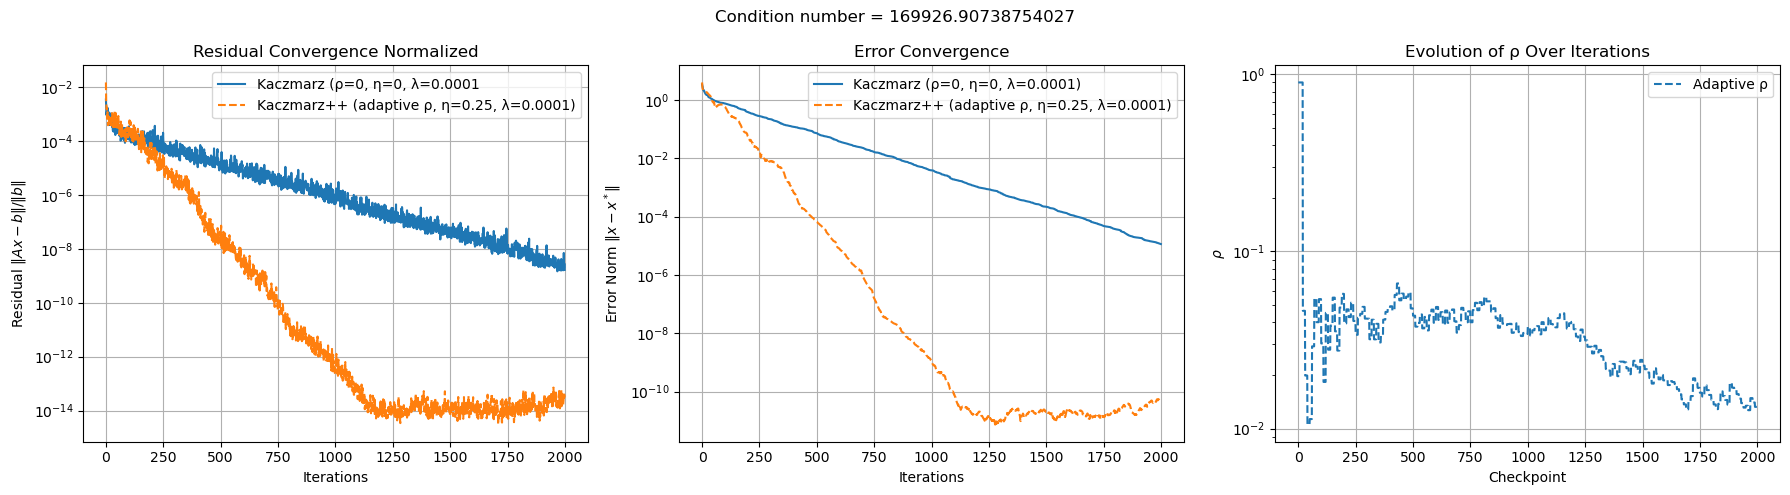

block size: 10


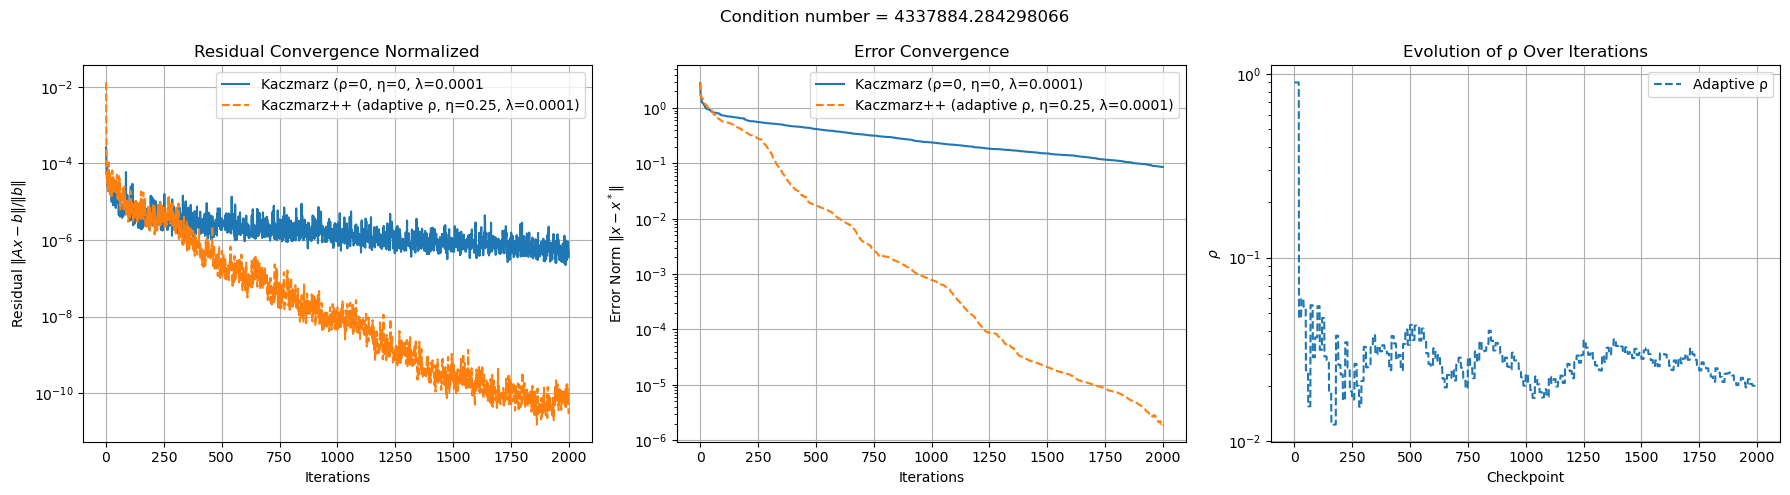

In [27]:
np.random.seed(42)

cond_values = np.array([1, 2, 3, 4, 5])

m = 50
n = 20

k_values = []

#block size, lambda
#s = optimal_s_lambda(A, 1, k)[0].astype(int)

for cond in cond_values:
    A, b, x_true, x_star = generate_rand_system(m, n, cond=cond, noise_std = 0)
    condition = np.linalg.cond(A)
    k = k_singular_values(A = A)
    k_values.append(k)
    #s = optimal_s_lambda(A, 1, k)[0].astype(int)
    s = 10
    print(f"block size: {s}")
    #lamb = optimal_s_lambda(A, 1, k)[1]
    lamb = 0.0001
    #lamb = calculate_lamda_mu_nu(A.T @ A, s)[0]
    eta = s/(2*n)
    #eta = 0.1
    lookback = 10 
    #no adaptive acceleration
    x_kacz_reg, residuals_reg, residual_norms_reg, update_norms_reg, errors_reg, rhos_reg = kaczmarz(A, b, lamb = lamb, accelerated =False, eta = 0, rho = 0, n_steps = 2000, block_size = s, p = lookback, x_true = x_true)
    #adaptive acceleration
    x_kacz_aa, residuals_reg_aa, residual_norms_aa, update_norms_reg_aa, errors_reg_aa, rhos_aa = kaczmarz(A, b, lamb = lamb, accelerated = True, eta = eta, rho = 0.9, n_steps = 2000, block_size = s, p = lookback, x_true = x_true)

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"Condition number = {condition}")

    # Residual
    axs[0].plot(residual_norms_reg, label=f"Kaczmarz (ρ=0, η=0, λ={lamb:.3g}")
    axs[0].plot(residual_norms_aa, label=f"Kaczmarz++ (adaptive ρ, η={eta:.3g}, λ={lamb:.3g})", linestyle='--')
    axs[0].set_yscale("log")
    axs[0].set_title("Residual Convergence Normalized")
    axs[0].set_xlabel("Iterations")
    axs[0].set_ylabel(r"Residual $\|Ax - b\| / \|b\|$")
    axs[0].legend()
    axs[0].grid(True)
    
    # Error
    axs[1].plot(errors_reg, label=f"Kaczmarz (ρ=0, η=0, λ={lamb:.3g})")
    axs[1].plot(errors_reg_aa, label=f"Kaczmarz++ (adaptive ρ, η={eta:.3g}, λ={lamb:.3g})", linestyle='--')
    axs[1].set_yscale("log")
    axs[1].set_title("Error Convergence")
    axs[1].set_xlabel("Iterations")
    axs[1].set_ylabel(r"Error Norm $\|x - x^*\|$")
    axs[1].legend()
    axs[1].grid(True)
    
    # Adaptive ρ
    axs[2].plot(rhos_aa, label="Adaptive ρ", linestyle='--')
    axs[2].set_yscale("log")
    axs[2].set_title("Evolution of ρ Over Iterations")
    axs[2].set_xlabel("Checkpoint")
    axs[2].set_ylabel(r"$\rho$")
    axs[2].legend()
    axs[2].grid(True)
    
    plt.tight_layout()
    plt.show()

In [220]:
np.random.seed(42)
C = generate_rand_system(1000,100,0)[0]

/tmp/ipykernel_7432/4066594780.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x_star = np.linalg.lstsq(A,b)[0] #even though b = Ax, block Kaczmarz projects onto minimum norm solution of Ax = b, i.e. x_star.


In [221]:
np.linalg.cond(C)

1.8826282144577735

In [222]:
k_singular_values(C)

17

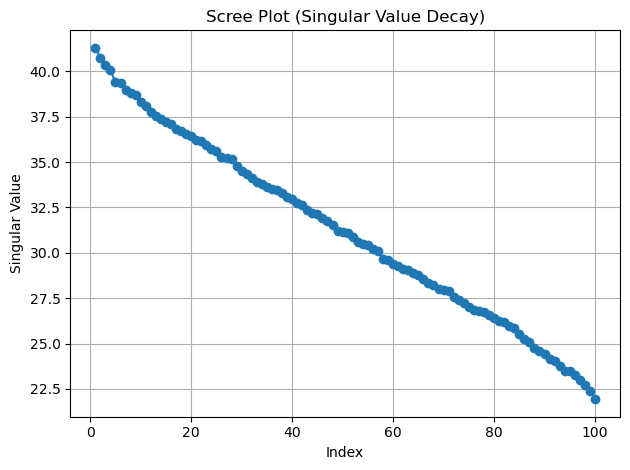

In [223]:

u,s,vt = np.linalg.svd(C)
plt.plot(np.arange(1, 100+1), s, marker='o')
plt.title("Scree Plot (Singular Value Decay)")
plt.xlabel("Index")
plt.ylabel("Singular Value")
plt.grid(True)
plt.tight_layout()
plt.show()


In [34]:
def calculate_lamda_mu_nu(A, k):
    """
    Estimate lambda, mu, and nu from A^T A.
    k is block size
    """
    s2 = np.linalg.eigvalsh(A)
    s2[s2 < np.mean(s2) * 1e-8] = 0

    def f(lamda):
        return np.sum(s2 / (s2 + lamda)) - k

    lamda = root_scalar(f, bracket=[1e-8, np.max(s2) * len(s2) * 1e8]).root
    s2_min = np.min(s2[s2 > 0])
    mu = s2_min / (s2_min + lamda)
    num = np.sum((s2 > 0) / (s2 + lamda))
    denom = np.sum(s2 / (s2 + lamda)**2)
    lamda_prime = lamda * num / denom
    nu = 1 + lamda_prime / (s2_min + lamda)

    return lamda, mu, nu

/var/folders/9g/0d0k7mbj6v39ndl2dz1yc49w0000gn/T/ipykernel_45296/1784429245.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x_star = np.linalg.lstsq(A,b)[0] #even though b = Ax, block Kaczmarz projects onto minimum norm solution of Ax = b, i.e. x_star.


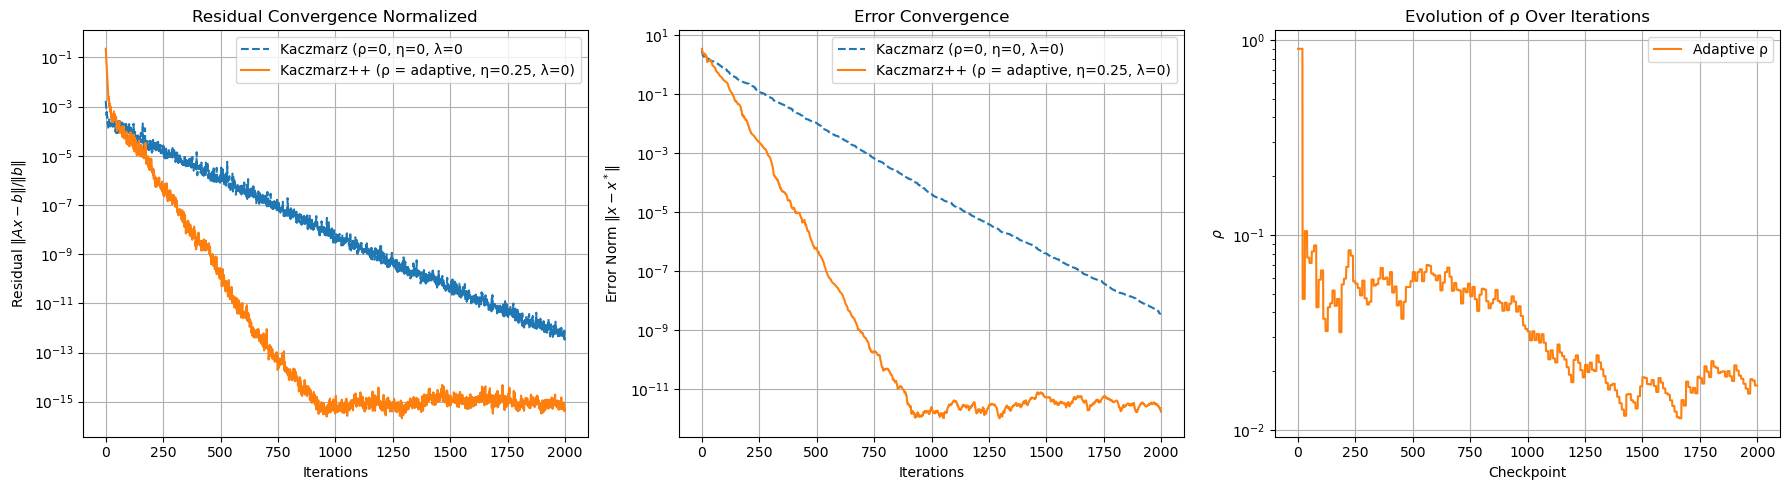

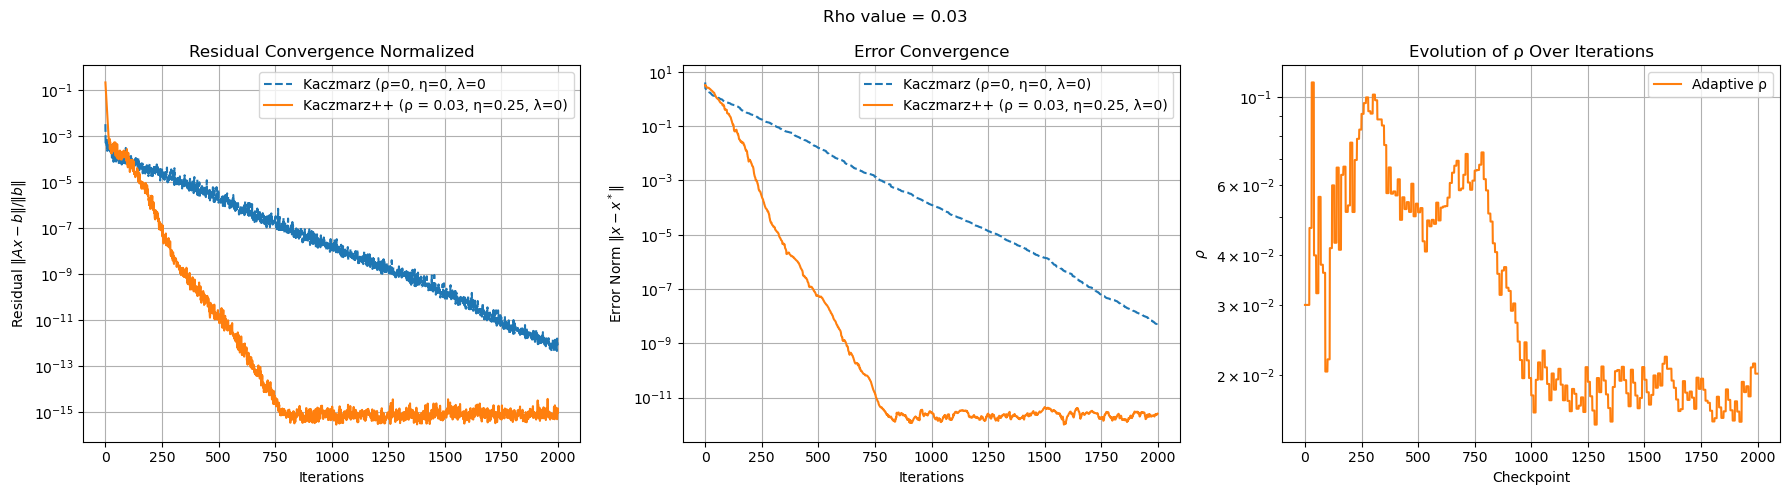

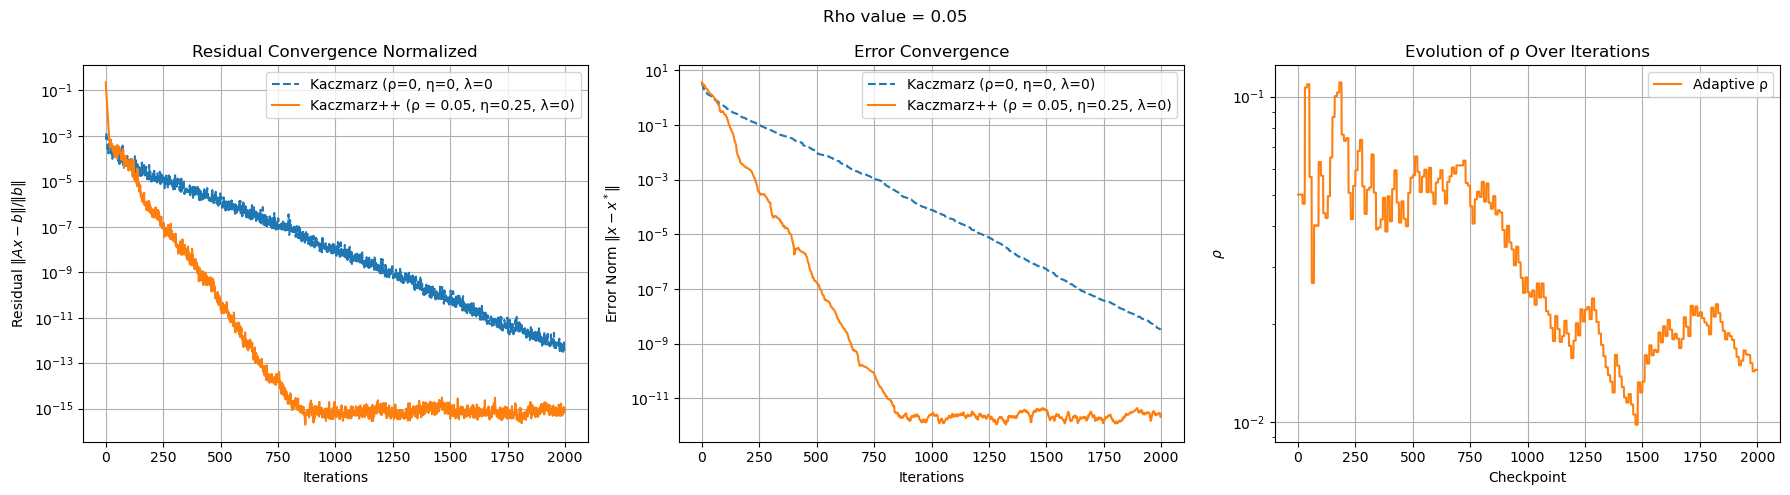

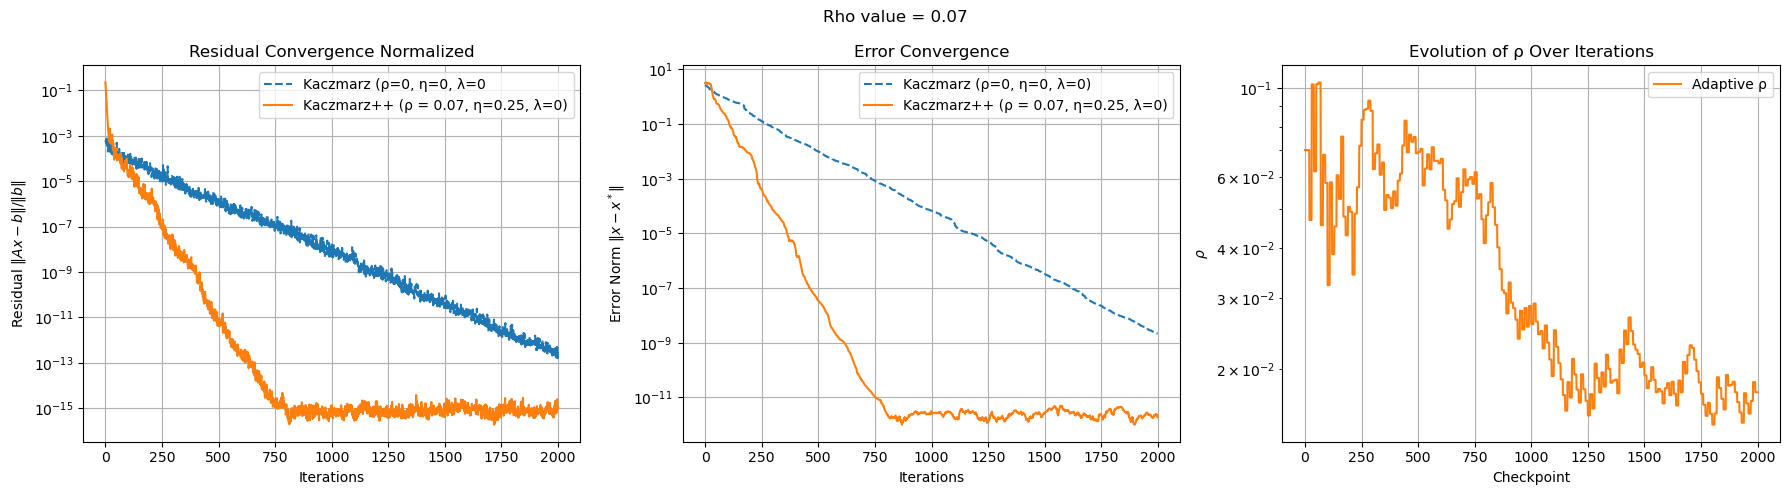

In [43]:
np.random.seed(42)

rho_values = np.array([0.03, 0.05, 0.07])

m = 50
n = 20
A, b, x_true, x_star = generate_rand_system(m, n, cond=3, noise_std = 0)

k_values = []

#block size, lambda
#s = optimal_s_lambda(A, 1, k)[0].astype(int)

lamb = 0 
s = 10
eta = s/(2*n)
lookback = 10 


#no adaptive acceleration
x_kacz_reg, residuals_reg, residual_norms_reg, update_norms_reg, errors_reg, rhos_reg = kaczmarz(A, b, lamb = lamb, accelerated =False, eta = 0, rho = 0, n_steps = 2000, block_size = s, p = lookback, x_true = x_true)
#adaptive acceleration
x_kacz_aa, residuals_reg_aa, residual_norms_aa, update_norms_reg_aa, errors_reg_aa, rhos_aa = kaczmarz(A, b, lamb = lamb, accelerated = True, eta = eta, rho = 0.9, n_steps = 2000, block_size = s, p = lookback, x_true = x_true)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Residual
axs[0].plot(residual_norms_reg, label=f"Kaczmarz (ρ=0, η=0, λ={lamb:.3g}", linestyle='--')
axs[0].plot(residual_norms_aa, label=f"Kaczmarz++ (ρ = adaptive, η={eta:.3g}, λ={lamb:.3g})")
axs[0].set_yscale("log")
axs[0].set_title("Residual Convergence Normalized")
axs[0].set_xlabel("Iterations")
axs[0].set_ylabel(r"Residual $\|Ax - b\| / \|b\|$")
axs[0].legend()
axs[0].grid(True)

# Error
axs[1].plot(errors_reg, label=f"Kaczmarz (ρ=0, η=0, λ={lamb:.3g})", linestyle='--')
axs[1].plot(errors_reg_aa, label=f"Kaczmarz++ (ρ = adaptive, η={eta:.3g}, λ={lamb:.3g})")
axs[1].set_yscale("log")
axs[1].set_title("Error Convergence")
axs[1].set_xlabel("Iterations")
axs[1].set_ylabel(r"Error Norm $\|x - x^*\|$")
axs[1].legend()
axs[1].grid(True)

# Adaptive ρ
axs[2].plot(rhos_aa, label="Adaptive ρ", color="tab:orange")
axs[2].set_yscale("log")
axs[2].set_title("Evolution of ρ Over Iterations")
axs[2].set_xlabel("Checkpoint")
axs[2].set_ylabel(r"$\rho$")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

for rhos in rho_values:
    #no adaptive acceleration
    x_kacz_reg, residuals_reg, residual_norms_reg, update_norms_reg, errors_reg, rhos_reg = kaczmarz(A, b, lamb = lamb, accelerated =False, eta = 0, rho = 0, n_steps = 2000, block_size = s, p = lookback, x_true = x_true)
    #adaptive acceleration
    x_kacz_aa, residuals_reg_aa, residual_norms_aa, update_norms_reg_aa, errors_reg_aa, rhos_aa = kaczmarz(A, b, lamb = lamb, accelerated = True, eta = eta, rho = rhos, n_steps = 2000, block_size = s, p = lookback, x_true = x_true)

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"Rho value = {rhos}")

    # Residual
    axs[0].plot(residual_norms_reg, label=f"Kaczmarz (ρ=0, η=0, λ={lamb:.3g}", linestyle='--')
    axs[0].plot(residual_norms_aa, label=f"Kaczmarz++ (ρ = {rhos}, η={eta:.3g}, λ={lamb:.3g})")
    axs[0].set_yscale("log")
    axs[0].set_title("Residual Convergence Normalized")
    axs[0].set_xlabel("Iterations")
    axs[0].set_ylabel(r"Residual $\|Ax - b\| / \|b\|$")
    axs[0].legend()
    axs[0].grid(True)
    
    # Error
    axs[1].plot(errors_reg, label=f"Kaczmarz (ρ=0, η=0, λ={lamb:.3g})", linestyle='--')
    axs[1].plot(errors_reg_aa, label=f"Kaczmarz++ (ρ = {rhos}, η={eta:.3g}, λ={lamb:.3g})")
    axs[1].set_yscale("log")
    axs[1].set_title("Error Convergence")
    axs[1].set_xlabel("Iterations")
    axs[1].set_ylabel(r"Error Norm $\|x - x^*\|$")
    axs[1].legend()
    axs[1].grid(True)
    
    # Adaptive ρ
    axs[2].plot(rhos_aa, label="Adaptive ρ", color="tab:orange")
    axs[2].set_yscale("log")
    axs[2].set_title("Evolution of ρ Over Iterations")
    axs[2].set_xlabel("Checkpoint")
    axs[2].set_ylabel(r"$\rho$")
    axs[2].legend()
    axs[2].grid(True)
    
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_19161/1784429245.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x_star = np.linalg.lstsq(A,b)[0] #even though b = Ax, block Kaczmarz projects onto minimum norm solution of Ax = b, i.e. x_star.
/tmp/ipykernel_19161/1903881045.py:33: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = np.linalg.lstsq(A_tau, A_tau @ x - b_tau)[0]


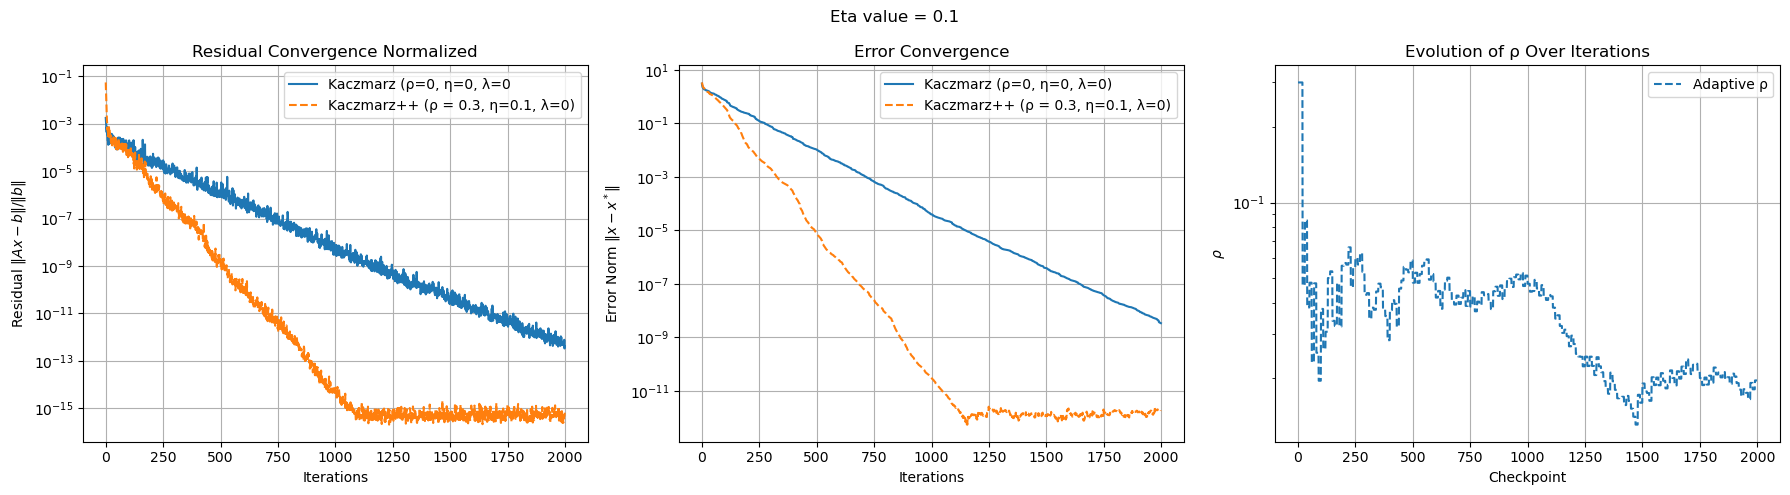

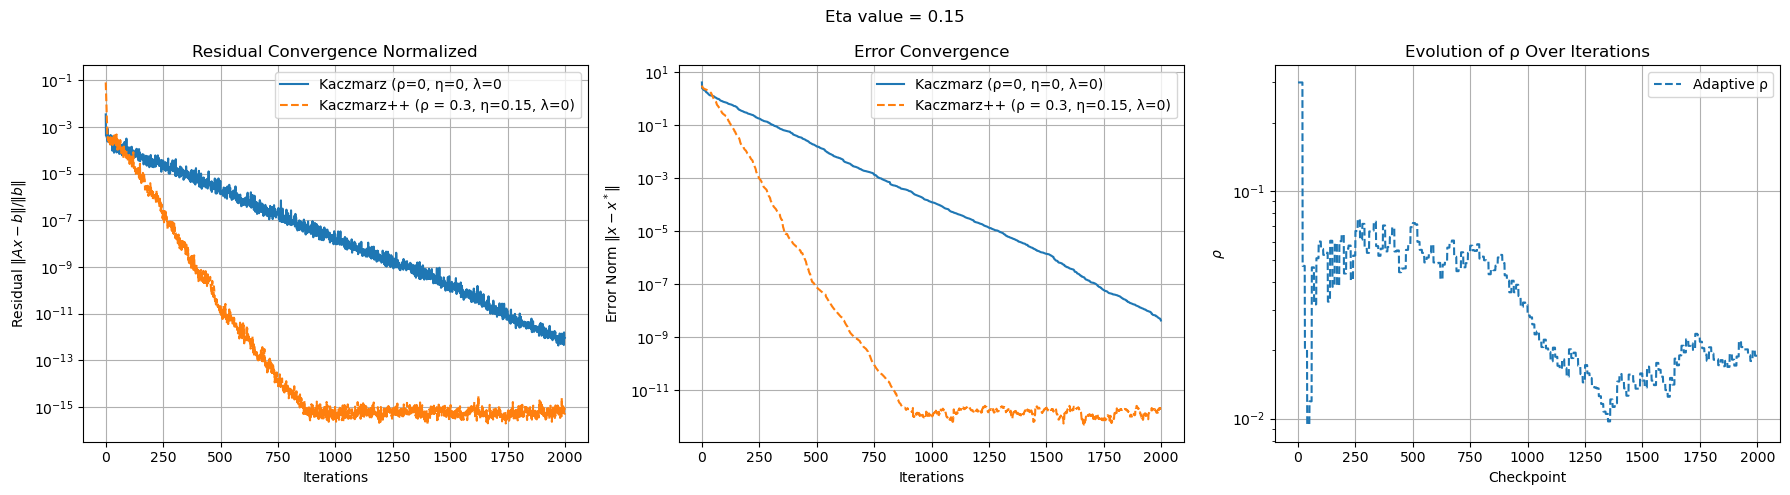

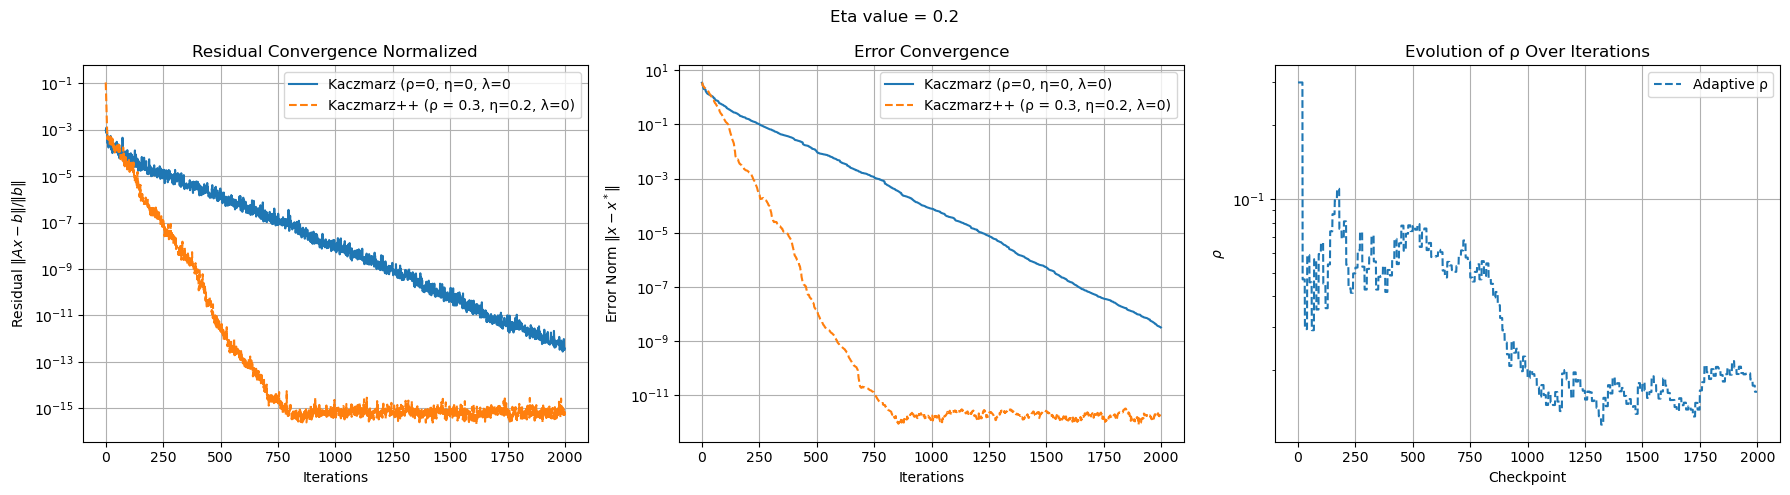

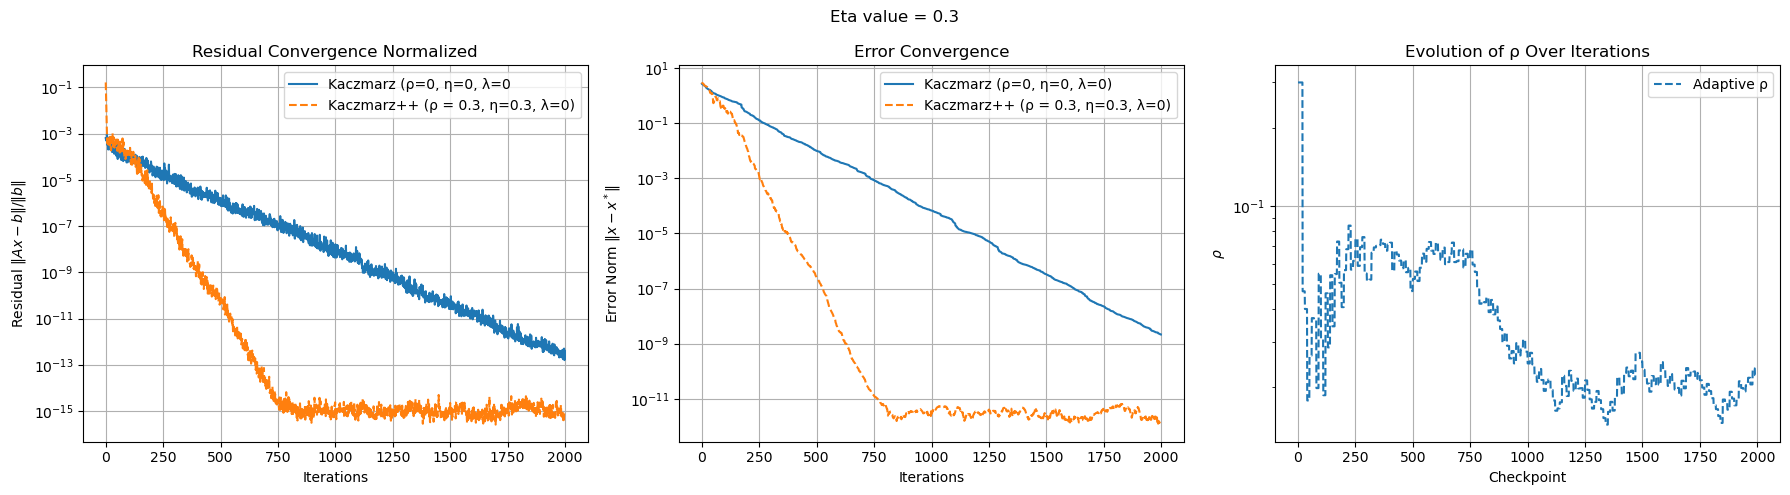

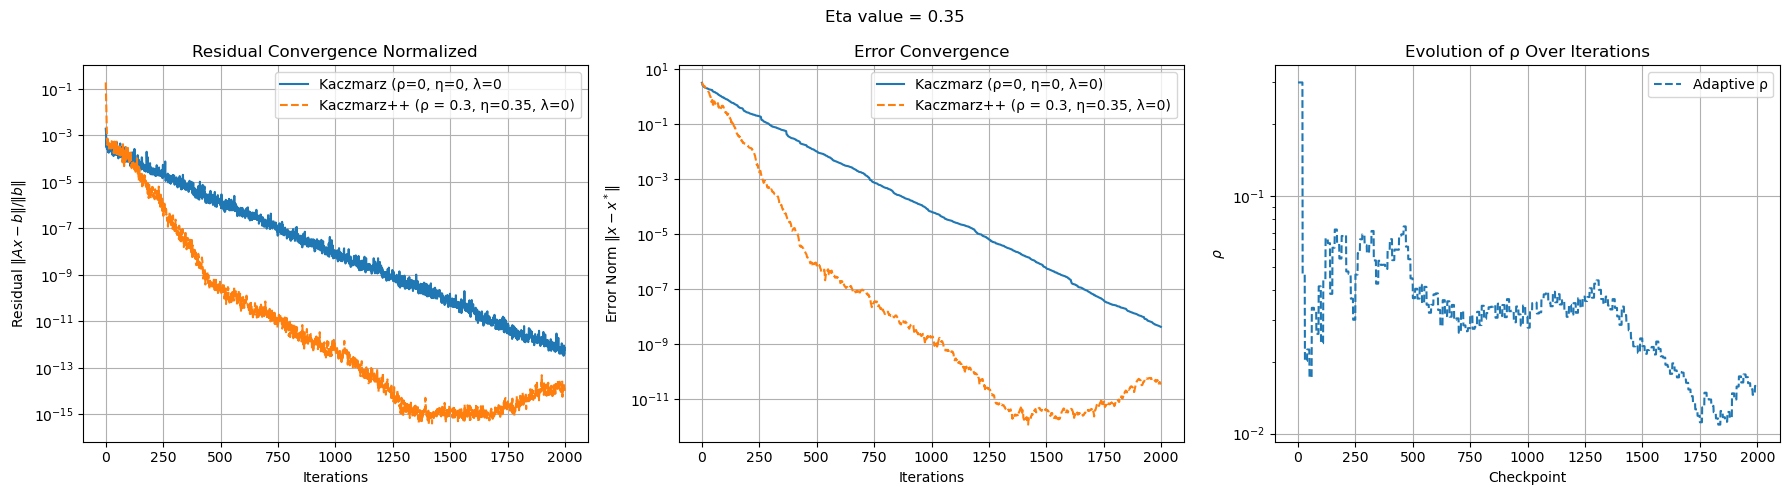

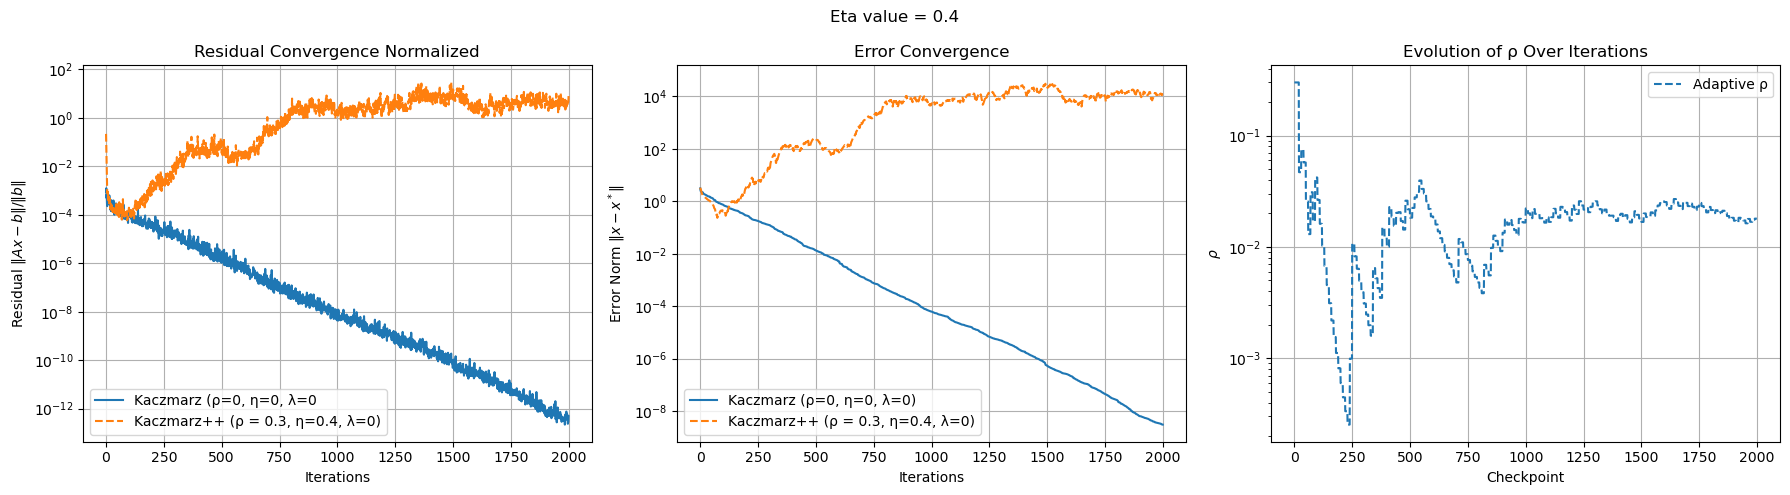

In [42]:
np.random.seed(42)

eta_values = np.array([0.1, 0.15, 0.2, 0.3, 0.35, 0.4])

m = 50
n = 20
A, b, x_true, x_star = generate_rand_system(m, n, cond=3, noise_std = 0)

k_values = []

#block size, lambda
#s = optimal_s_lambda(A, 1, k)[0].astype(int)

lamb = 0 
s = 10
#eta = s/(2*n)
lookback = 10 

for eta in eta_values:
    #no adaptive acceleration
    x_kacz_reg, residuals_reg, residual_norms_reg, update_norms_reg, errors_reg, rhos_reg = kaczmarz(A, b, lamb = lamb, accelerated =False, eta = 0, rho = 0, n_steps = 2000, block_size = s, p = lookback, x_true = x_true)
    #adaptive acceleration
    x_kacz_aa, residuals_reg_aa, residual_norms_aa, update_norms_reg_aa, errors_reg_aa, rhos_aa = kaczmarz(A, b, lamb = lamb, accelerated = True, eta = eta, rho = rhos, n_steps = 2000, block_size = s, p = lookback, x_true = x_true)

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"Eta value = {eta}")

    # Residual
    axs[0].plot(residual_norms_reg, label=f"Kaczmarz (ρ=0, η=0, λ={lamb:.3g}")
    axs[0].plot(residual_norms_aa, label=f"Kaczmarz++ (ρ = {rhos}, η={eta:.3g}, λ={lamb:.3g})", linestyle='--')
    axs[0].set_yscale("log")
    axs[0].set_title("Residual Convergence Normalized")
    axs[0].set_xlabel("Iterations")
    axs[0].set_ylabel(r"Residual $\|Ax - b\| / \|b\|$")
    axs[0].legend()
    axs[0].grid(True)
    
    # Error
    axs[1].plot(errors_reg, label=f"Kaczmarz (ρ=0, η=0, λ={lamb:.3g})")
    axs[1].plot(errors_reg_aa, label=f"Kaczmarz++ (ρ = {rhos}, η={eta:.3g}, λ={lamb:.3g})", linestyle='--')
    axs[1].set_yscale("log")
    axs[1].set_title("Error Convergence")
    axs[1].set_xlabel("Iterations")
    axs[1].set_ylabel(r"Error Norm $\|x - x^*\|$")
    axs[1].legend()
    axs[1].grid(True)
    
    # Adaptive ρ
    axs[2].plot(rhos_aa, label="Adaptive ρ", linestyle='--')
    axs[2].set_yscale("log")
    axs[2].set_title("Evolution of ρ Over Iterations")
    axs[2].set_xlabel("Checkpoint")
    axs[2].set_ylabel(r"$\rho$")
    axs[2].legend()
    axs[2].grid(True)
    
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_19161/1784429245.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x_star = np.linalg.lstsq(A,b)[0] #even though b = Ax, block Kaczmarz projects onto minimum norm solution of Ax = b, i.e. x_star.


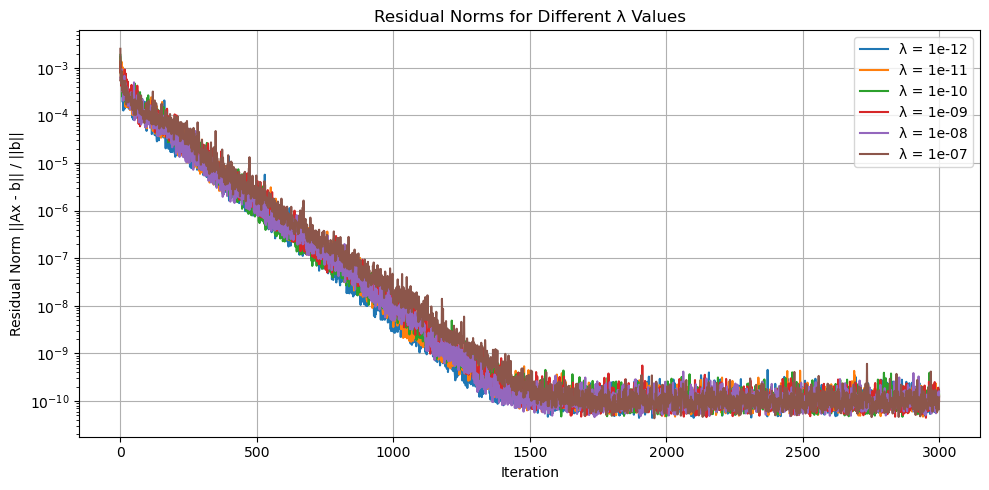

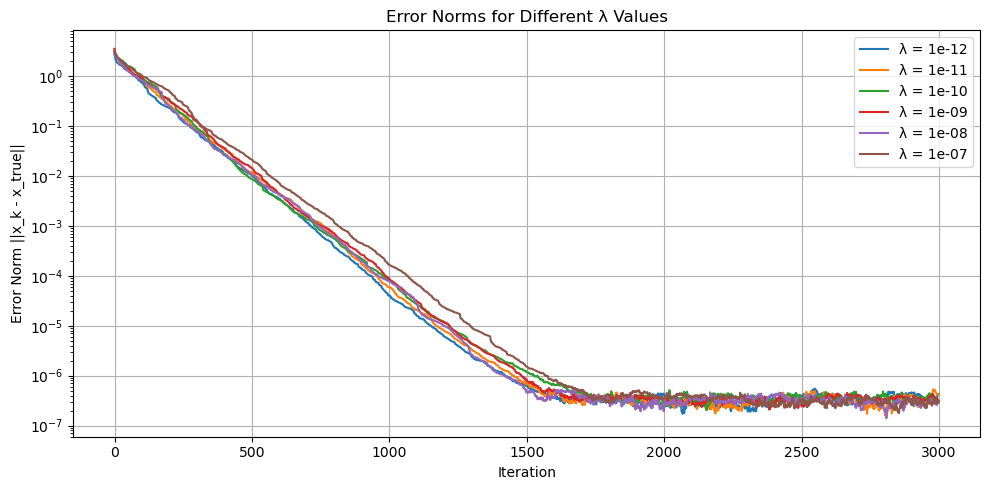

In [171]:
np.random.seed(42)
noise = 1e-10
m = 50
n = 20
A, b, x_true, x_star = generate_rand_system(m, n, cond=3, noise_std = noise)
s = 10
lookback = 10
eta = s/(2*n)

lamb_values = [1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7] #1e-6, 1e-5, 1e-4, 0.00055, 1e-3, 1e-2, 1e-1, 1

residuals_dict = {}
errors_dict = {}

for lamb in lamb_values:
    x_kacz_reg, residuals_reg, residual_norms_reg, update_norms_reg, errors_reg, rhos_reg = kaczmarz(A, b, lamb = lamb, accelerated = False, eta = 0, rho = 0, n_steps = 3000, block_size = s, p = lookback, x_true = x_true)
    residuals_dict[lamb] = residual_norms_reg
    errors_dict[lamb] = errors_reg

plt.figure(figsize=(10, 5))
for lamb in lamb_values:
    plt.plot(residuals_dict[lamb], label=f"λ = {lamb}")
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Residual Norm ||Ax - b|| / ||b||")
plt.title("Residual Norms for Different λ Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot errors
plt.figure(figsize=(10, 5))
for lamb in lamb_values:
    plt.plot(errors_dict[lamb], label=f"λ = {lamb}")
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Error Norm ||x_k - x_true||")
plt.title("Error Norms for Different λ Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipykernel_19161/1784429245.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x_star = np.linalg.lstsq(A,b)[0] #even though b = Ax, block Kaczmarz projects onto minimum norm solution of Ax = b, i.e. x_star.


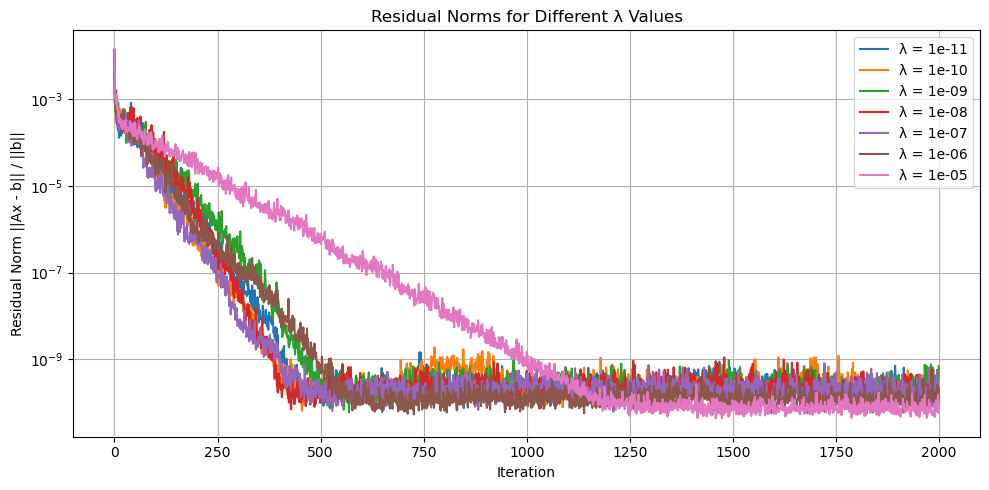

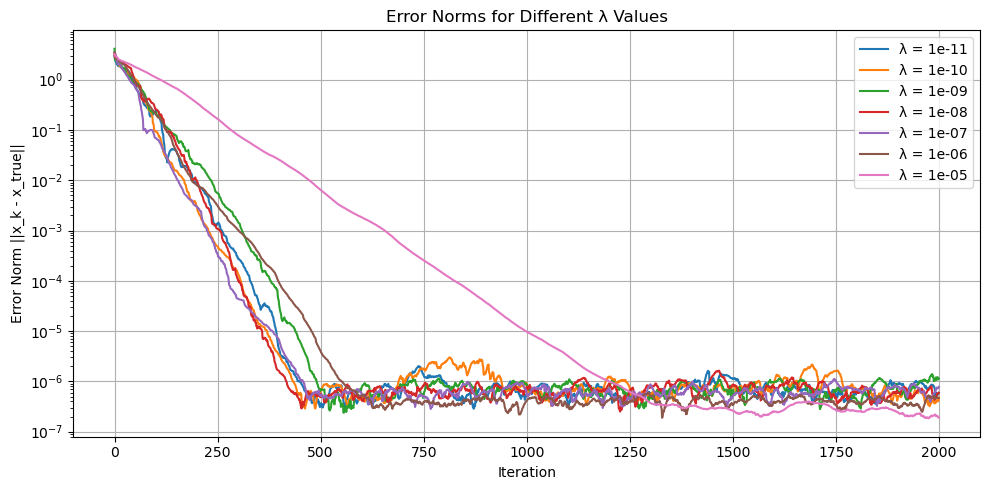

In [170]:
np.random.seed(42)
noise = 1e-10
m = 50
n = 20
A, b, x_true, x_star = generate_rand_system(m, n, cond=3, noise_std = noise)
s = 10
lookback = 10
eta = s/(2*n)

lamb_values = [1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5] #1e-4, 0.00055, 1e-3, 1e-2, 1e-1, 1, 10

residuals_dict = {}
errors_dict = {}

for lamb in lamb_values:
    x_kacz_aa, residuals_reg_aa, residual_norms_aa, update_norms_reg_aa, errors_aa, rhos_aa = kaczmarz(A, b, lamb = lamb, accelerated = True, eta = eta, rho = 0.9, n_steps = 2000, block_size = s, p = lookback, x_true = x_true)
    residuals_dict[lamb] = residual_norms_aa
    errors_dict[lamb] = errors_aa

plt.figure(figsize=(10, 5))
for lamb in lamb_values:
    plt.plot(residuals_dict[lamb], label=f"λ = {lamb}")
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Residual Norm ||Ax - b|| / ||b||")
plt.title("Residual Norms for Different λ Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot errors
plt.figure(figsize=(10, 5))
for lamb in lamb_values:
    plt.plot(errors_dict[lamb], label=f"λ = {lamb}")
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Error Norm ||x_k - x_true||")
plt.title("Error Norms for Different λ Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/9g/0d0k7mbj6v39ndl2dz1yc49w0000gn/T/ipykernel_45296/1784429245.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x_star = np.linalg.lstsq(A,b)[0] #even though b = Ax, block Kaczmarz projects onto minimum norm solution of Ax = b, i.e. x_star.


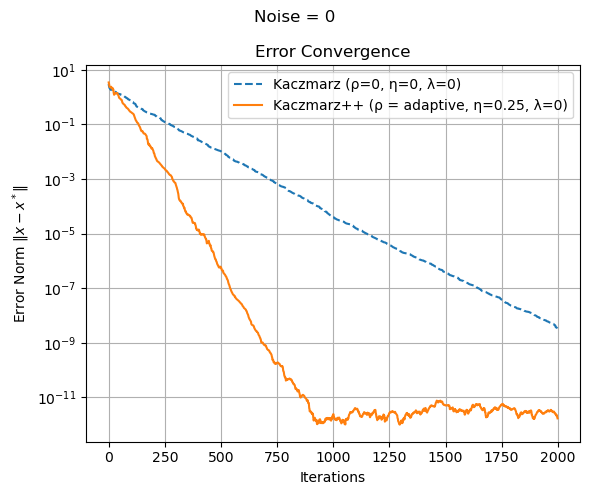

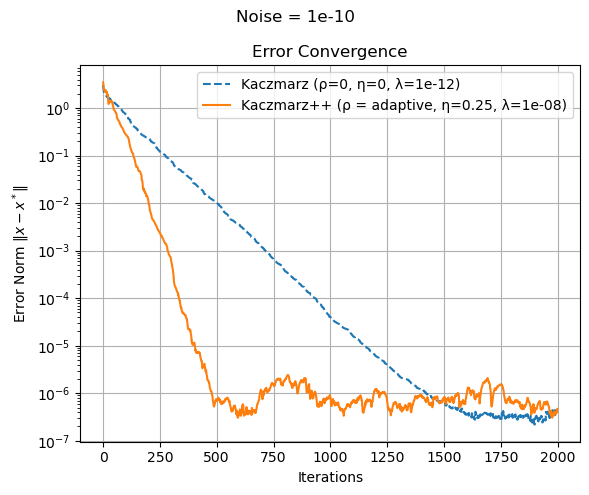

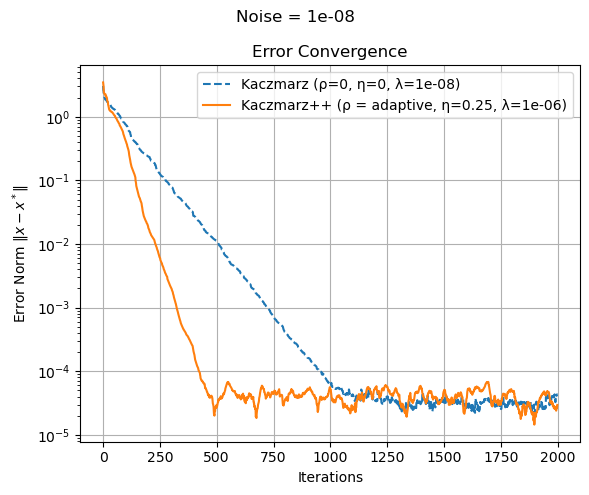

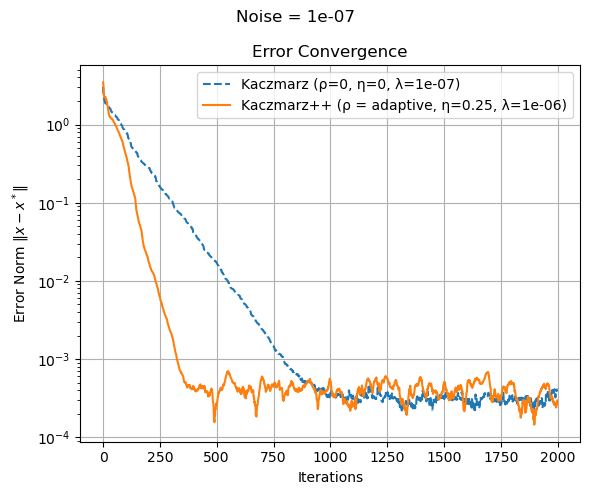

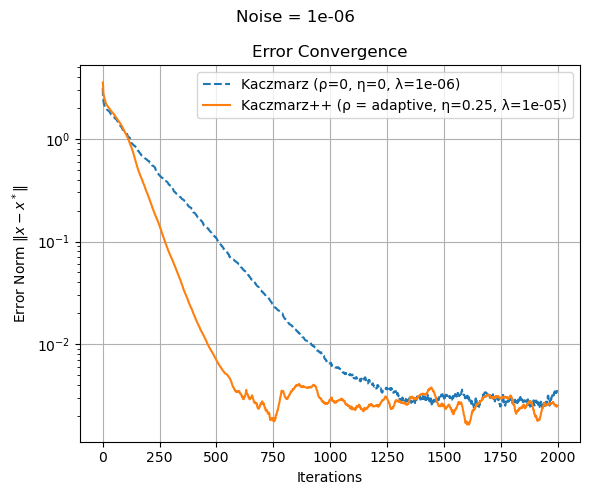

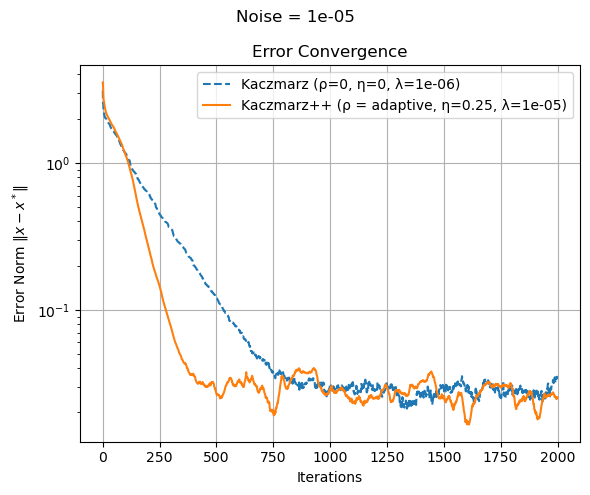

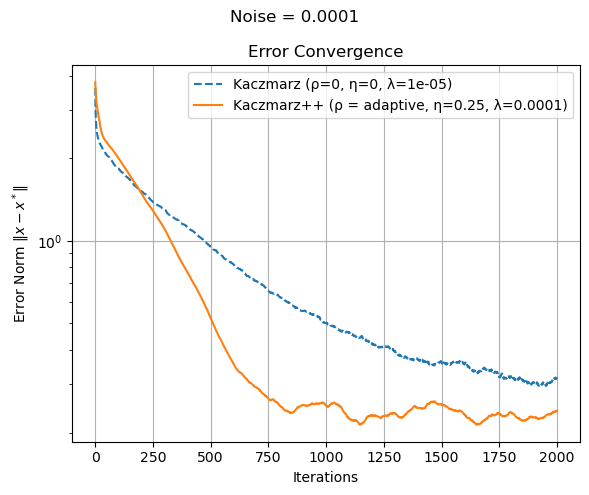

In [48]:

#keys = noise_std, values = (lambda for reg, lambda for aa)
optimal_lambdas_per_noise = {0: (0,0), 1e-10: (1e-12, 1e-8), 1e-8: (1e-8, 1e-6), 1e-7: (1e-7, 1e-6), 1e-6: (1e-6, 1e-5), 1e-5: (1e-6, 1e-5), 0.0001: (1e-5, 1e-4)} # 0.001: (0.0001, 0.001), 0.01: (0.1, 1)

m = 50
n = 20

s = 10
eta = s/(2*n)
lookback = 10 

for noise in sorted(optimal_lambdas_per_noise.keys()):
    np.random.seed(42)
    A, b, x_true, x_star = generate_rand_system(m, n, cond=3, noise_std = noise)
    lamb_reg = optimal_lambdas_per_noise[noise][0]
    lamb_aa = optimal_lambdas_per_noise[noise][1]
    #no adaptive acceleration
    x_kacz_reg, residuals_reg, residual_norms_reg, update_norms_reg, errors_reg, rhos_reg = kaczmarz(A, b, lamb = lamb_reg, accelerated =False, eta = 0, rho = 0, n_steps = 2000, block_size = s, p = lookback, x_true = x_true)
    #adaptive acceleration
    x_kacz_aa, residuals_reg_aa, residual_norms_aa, update_norms_reg_aa, errors_reg_aa, rhos_aa = kaczmarz(A, b, lamb = lamb_aa, accelerated = True, eta = eta, rho = 0.9, n_steps = 2000, block_size = s, p = lookback, x_true = x_true)
    
    #beta = (1 - np.array(rhos_aa))/(1 + np.array(rhos_aa))
    fig, axs = plt.subplots(1, 1, figsize=(6, 5))
    fig.suptitle(f"Noise = {noise}")

    # Residual
#     axs[0].plot(residual_norms_reg, label=f"Kaczmarz (ρ=0, η=0, λ={lamb_reg:.3g}")
#     axs[0].plot(residual_norms_aa, label=f"Kaczmarz++ (ρ = adaptive, η={eta:.3g}, λ={lamb_aa:.3g})", linestyle='--')
#     axs[0].set_yscale("log")
#     axs[0].set_title("Residual Convergence Normalized")
#     axs[0].set_xlabel("Iterations")
#     axs[0].set_ylabel(r"Residual $\|Ax - b\| / \|b\|$")
#     axs[0].legend()
#     axs[0].grid(True)
    
    # Error
    axs.plot(errors_reg, label=f"Kaczmarz (ρ=0, η=0, λ={lamb_reg:.3g})", linestyle="--")
    axs.plot(errors_reg_aa, label=f"Kaczmarz++ (ρ = adaptive, η={eta:.3g}, λ={lamb_aa:.3g})")
    axs.set_yscale("log")
    axs.set_title("Error Convergence")
    axs.set_xlabel("Iterations")
    axs.set_ylabel(r"Error Norm $\|x - x^*\|$")
    axs.legend()
    axs.grid(True)
    
#     # Adaptive ρ
#     axs[1].plot(rhos_aa, label="Adaptive β", color="tab:orange")
#     #axs[1].set_yscale("log")
#     axs[1].set_title("Evolution of β Over Iterations")
#     axs[1].set_xlabel("Iterations")
#     axs[1].set_ylabel(r"$\beta$")
#     axs[1].legend()
#     axs[1].grid(True)
    
    plt.tight_layout()
    plt.show()